# CARDIOVASCULAR CATH DISEASE

## The Cardio Catch Diseases (CCD) Company
Cadio Catch Diseases is a company that specializes in detecting heart disease in the early stages. Its business model is Service type, that is, the company offers an early diagnosis of cardiovascular disease for a certain price.

Currently, the diagnosis of cardiovascular disease is made manually by a team of specialists. The current accuracy of the diagnosis varies between 55% and 65%, due to the complexity of the diagnosis and also the fatigue of the team who take turns to minimize the risks. The cost of each diagnosis, including the devices and the payroll of the analysts, is around R $ 1,000.00.

The price of the diagnosis, paid by the client, varies according to the precision achieved by the team of specialists, the client pays R $ 500.00 for every 5% accuracy above 50%. For example, for an accuracy of 55%, the diagnosis costs R $ 500.00 for the client, for an accuracy of 60%, the value is R $ 1000.00 and so on. If the diagnostic accuracy is 50%, the customer does not pay for it.

Note that the variation in precision given by the team of specialists, makes the company either have a profitable operation, revenue greater than the cost, or an operation at a loss, revenue less than the cost. This instability of the diagnosis makes the company to have an unpredictable Cashflow.

Your objective as the Data Scientist hired by Cardio Catch Diseases is to create a tool that increases the accuracy of the diagnosis and that this accuracy is stable for all diagnoses.

So your job as a Data Scientist is to create a patient classification tool, such as stable accuracy. Along with the tool, you need to send a report to the CEO of Cardio Catch Diseases, reporting the results and answering the following questions: (He will probably ask these questions on the day of your presentation.)

What is the Accuracy and Precision of the tool?
How much profit will Cardio Catch Diseases have with the new tool?
How Reliable is the result given by the new tool?
The Challenge Data
The data set that will be used to create the solution for Cardio Catch Diseases, is available on the Kaggle platform.

This is the link: Cardiovascular Disease dataset

This data set contains 70,000 patient diagnoses. You will use this data to create your solution.

# 0.0 IMPUTS

## 0.1 Imports

In [1]:
import csv
import pickle
import warnings
warnings.filterwarnings( 'ignore' )

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import seaborn             as sns
import statistics          as st
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.ensemble          import RandomForestClassifier
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model      import LogisticRegression, SGDClassifier

## 0.2 Helpers Functions

In [2]:
# sets global SEED
SEED = 42

In [3]:
# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['font.size'] = 25
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def calcBMI(weight, height):
    #BMI = kg/m2
    bmi = np.round(weight / (height**2), 1)
    
    return bmi

def BMI(bmi):
    if bmi < 18.5:
        status = "Underweight"
    
    elif bmi >= 18.5 and bmi <= 24.9:
        status = "Healthy"
    
    elif bmi >= 25.0 and bmi <= 29.9:
        status = "Overweight"
        
    elif bmi >= 30.0:
        status = "Obese"
        
    return status

In [5]:
def cardio_table (dataframe, column):
    
    aux = dataframe[[column, 'cardio_disease']].groupby(column).sum().reset_index()
    
    aux['Total_Pacients'] = dataframe[[column, 'cardio_disease']].groupby(column).count().reset_index()['cardio_disease']
    aux.columns = [column, 'cardio_disease_1', 'Total_Patients']
    aux['Cardiac Patients Ratio (%)'] = np.round(((aux['cardio_disease_1'] / aux['Total_Patients'])*100), decimals=2)
    aux['Patients Percentage'] = np.round(((aux['Total_Patients'] / (aux['Total_Patients'].sum()))*100), decimals=2)
    aux.rename(columns={'cardio_disease_1': 'Cardiac Patients'})
    
    return aux

In [6]:
def cramer_v(x,y):

    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r , k = cm.shape

    chi2 = ss.chi2_contingency ( cm )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ))

In [7]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs(( y - yhat ) / y ))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])

def mean_percentage_error( y, yhat ):
    return np.mean(( y - yhat ) / y )

In [8]:
def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold + 1 )):
        if verbose:
            print ('/nKFold Number: {}'.format( k ))
        # start and end date for validation
        validation_start = x_training['id'].max() -  (k*6)
        validation_end = x_training['id'].max() -  ((k-1)*6)

        # filtering dataset
        training = x_training[x_training['id'] < validation_start]
        validation = x_training[( x_training['id'] >= validation_start) & (x_training['id'] <= validation_end)]

        # training and validation dataset:
         # training
        xtraining = training.drop( ['cardio_disease_1', 'id'], axis = 1 )
        ytraining = training['cardio_disease_1']

         # validation
        xvalidation = validation.drop( ['cardio_disease_1', 'id'], axis = 1 )
        yvalidation = validation['cardio_disease_1']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, yvalidation, yhat )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list), 2).astype( str ) + ' +/- ' + np.round(np.std( mae_list), 2).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2).astype( str ) + ' +/- ' + np.round(np.std( mape_list), 2).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list), 2).astype( str ) + ' +/- ' + np.round(np.std( rmse_list), 2).astype( str )}, index = [0])

## 0.3 Loading Data

In [9]:
df_cardio_raw = pd.read_csv('data/cardio_train.csv', low_memory= False, delimiter=';')

# 1.0 DATA DESCRIPTION

In [10]:
df1 = df_cardio_raw.copy()

In [11]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.00000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.00000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.00000,100,60,1,1,0,0,0,0


## 1.1 Features Description

There are 3 types of input features:

**Objective:** factual information;

**Examination:** results of medical examination;

**Subjective:** information given by the patient.


### Features:

**- Age** | Objective Feature | age | int (days)

**- Height** | Objective Feature | height | int (cm) |

**- Weight** | Objective Feature | weight | float (kg) |

**- Gender** | Objective Feature | gender | categorical code |

**- Systolic blood pressure** | Examination Feature | ap_hi | int |

**- Diastolic blood pressure** | Examination Feature | ap_lo | int |

**- Cholesterol** | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

**- Glucose** | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

**- Smoking** | Subjective Feature | smoke | binary |

**- Alcohol intake** | Subjective Feature | alco | binary |

**- Physical activity** | Subjective Feature | active | binary |

**- Presence or absence of cardiovascular disease** | Target Variable | cardio | binary |


All of the dataset values were collected at the moment of medical examination.

## 1.2 Rename Columns

In [12]:
new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose",
              "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "cardio_disease"}

df1.rename(columns=new_columns, inplace=True)

df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease
0,0,18393,2,168,62.00000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.00000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.00000,100,60,1,1,0,0,0,0


## 1.3 Data Dimentions

In [13]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of cols: 13


## 1.4 Data Types

In [14]:
df1.dtypes

id                            int64
age                           int64
gender                        int64
height                        int64
weight                      float64
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                   int64
glucose                       int64
smoking                       int64
alcohol                       int64
physical_activity             int64
cardio_disease                int64
dtype: object

## 1.5 Check NA

In [15]:
df1.isna().sum()

id                          0
age                         0
gender                      0
height                      0
weight                      0
systolic_blood_pressure     0
diastolic_blood_pressure    0
cholesterol                 0
glucose                     0
smoking                     0
alcohol                     0
physical_activity           0
cardio_disease              0
dtype: int64

## 1.6 Change Types

We're going to convert the age units from days to years so it becomes easier to interpret and check if there is any outlier. However, for the future calculations, we're going to keep the days column, because there's a chance that we may lose information by rounding the data.

In [16]:
# converting days to years
df1['age_years'] = ((df1['age'])/365).round(2)
df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years
0,0,18393,2,168,62.00000,110,80,1,1,0,0,1,0,50.39000
1,1,20228,1,156,85.00000,140,90,3,1,0,0,1,1,55.42000
2,2,18857,1,165,64.00000,130,70,3,1,0,0,0,1,51.66000
3,3,17623,2,169,82.00000,150,100,1,1,0,0,1,1,48.28000
4,4,17474,1,156,56.00000,100,60,1,1,0,0,0,0,47.87000


**Gender** can be estimated by **height**, as men are on average taller than women of the same age.

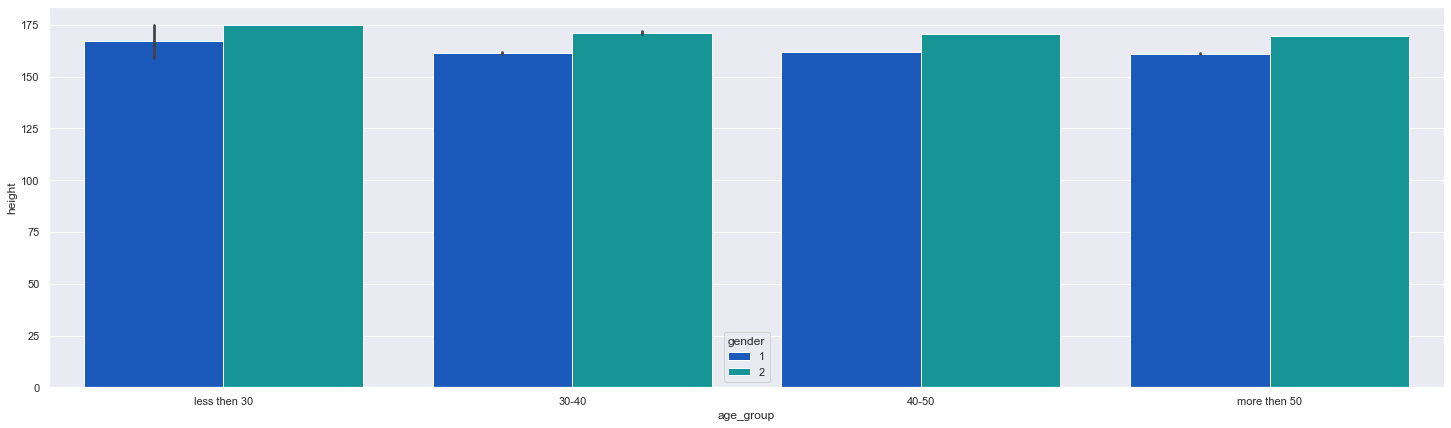

In [17]:
sns.set(rc={'figure.figsize':(25,7)})

df1['age_group'] = df1['age_years'].apply( lambda x: 'less then 30' if x <= 30 else 
                                         ( '30-40' if 30<x<= 40 else 
                                          ( '40-50' if 40<x<= 50 else 'more then 50' )))

sns.barplot( x = 'age_group', y = 'height', data = df1, hue = 'gender', palette = 'winter', order = ['less then 30', '30-40', '40-50', 'more then 50']);

In [18]:
df1['gender'] = df1['gender'].apply( lambda x: 'women' if x == 2 else 'men')


# changing the descriptions contained at Features Description for exploratory data analysis:
df1['cholesterol'] = df1['cholesterol'].apply( lambda x: 'normal' if x == 1 else 'above normal' if x == 2 else 'well above normal')
df1['glucose'] = df1['glucose'].apply( lambda x: 'normal' if x == 1 else 'above normal' if x == 2 else 'well above normal')

# transforming float in int number:
df1['weight'] = df1['weight'].astype(int)

In [19]:
df1.dtypes

id                            int64
age                           int64
gender                       object
height                        int64
weight                        int32
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                  object
glucose                      object
smoking                       int64
alcohol                       int64
physical_activity             int64
cardio_disease                int64
age_years                   float64
age_group                    object
dtype: object

**Data types :** float64 (1), int32 (1), int64 (9), object (4).

## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00000,99999.00000,99999.00000,49972.41990,50001.50000,28851.09624,-0.00128,-1.19837
1,age,10798.00000,23713.00000,12915.00000,19468.86581,19703.00000,2467.23404,-0.30706,-0.82345
2,height,55.00000,250.00000,195.00000,164.35923,165.00000,8.21007,-0.64219,7.94365
3,weight,10.00000,200.00000,190.00000,74.20433,72.00000,14.39585,1.01203,2.58675
4,systolic_blood_pressure,-150.00000,16020.00000,16170.00000,128.81729,120.00000,154.01032,85.29621,7580.07474
5,diastolic_blood_pressure,-70.00000,11000.00000,11070.00000,96.63041,80.00000,188.47118,32.11408,1425.91458
6,smoking,0.00000,1.00000,1.00000,0.08813,0.00000,0.28348,2.90587,6.44425
7,alcohol,0.00000,1.00000,1.00000,0.05377,0.00000,0.22557,3.95661,13.65513
8,physical_activity,0.00000,1.00000,1.00000,0.80373,1.00000,0.39718,-1.52947,0.33930
9,cardio_disease,0.00000,1.00000,1.00000,0.49970,0.00000,0.50000,0.00120,-2.00006


In the data we can see possible outliers:


- Minimum **height** = 55.00, and minimum **weight** = 10.00, when **age_years** = 29.58;

- Maximum blood pressure **systolic_blood_pressure** = 16170.00 and **diastolic_blood_pressure** = 11070.00.
- Minimum blood pressure **systolic_blood_pressure** and **diastolic_blood_pressure** negatives.

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender         2
cholesterol    3
glucose        3
age_group      4
dtype: int64

<AxesSubplot:xlabel='glucose', ylabel='count'>

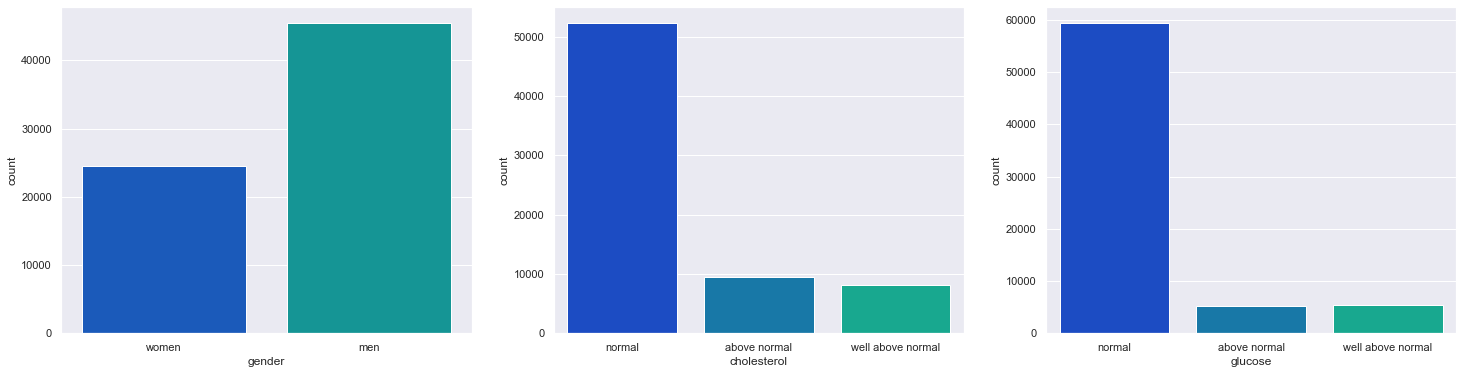

In [23]:
sns.set(rc={'figure.figsize':(25,6)})

plt.subplot(1,3,1)
sns.countplot(df1['gender'], palette = 'winter')

plt.subplot(1,3,2)
sns.countplot(df1['cholesterol'], palette = 'winter', order = ['normal', 'above normal', 'well above normal'])

plt.subplot(1,3,3)
sns.countplot(df1['glucose'], palette = 'winter')


## 1.8 Outliers

### 1.8.1 Checking outliers

Text(0.5, 1.0, 'Weight x Height')

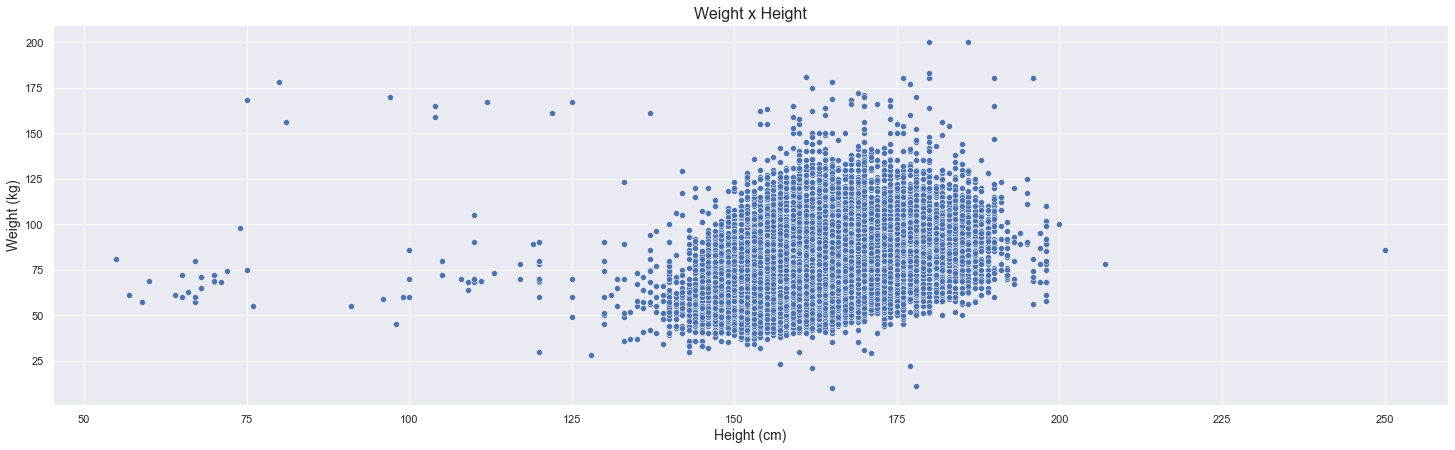

In [24]:
sns.set(rc={'figure.figsize':(25,7)})

sns.scatterplot(x="height", y="weight", data = df1, palette = 'winter')
plt.xlabel("Height (cm)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)
plt.title("Weight x Height", fontsize=16)

In this graph, we can see the presence of some outliers in addition to those we saw in the Numerical Attributes table. We will analyze the "height" and "weight" variables separately to define the outliers limits.

Text(0.5, 1.0, 'Weight x Age')

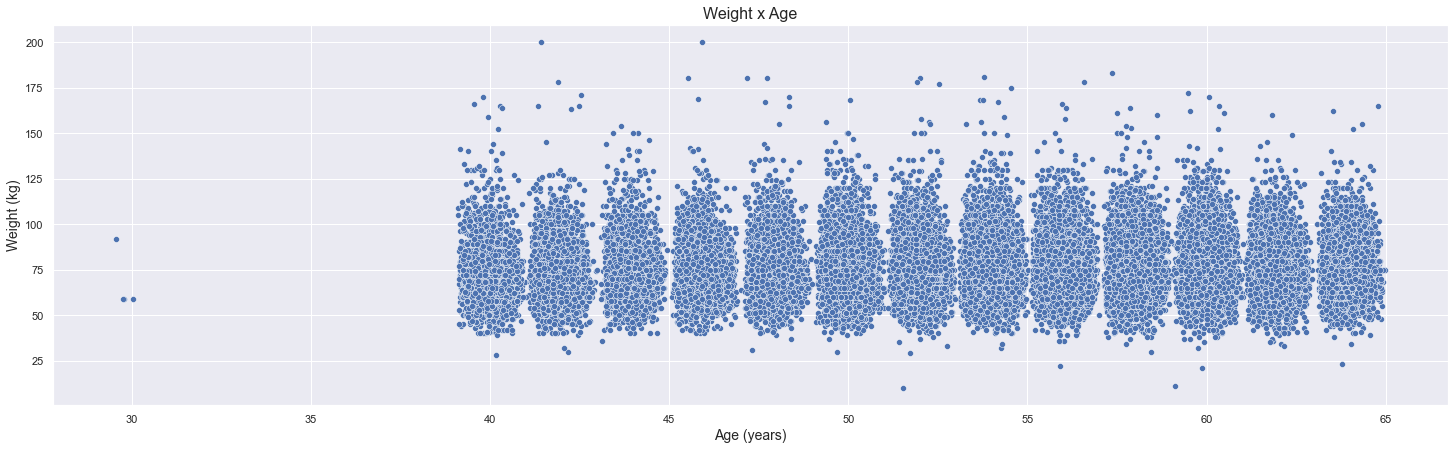

In [25]:
sns.set(rc={'figure.figsize':(25,7)})

sns.scatterplot(x='age_years', y='weight', data=df1, palette = 'winter')
#sns.scatterplot(data = df1, x = 'age_years', y = 'weight', hue='weight', palette = 'winter');
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)
plt.title("Weight x Age", fontsize=16)

**Ages** lower than 35 years will be considered outliers.

Points in **weight** lower then 40 kg, will be considered outliers.

Text(0.5, 1.0, 'Height x Age')

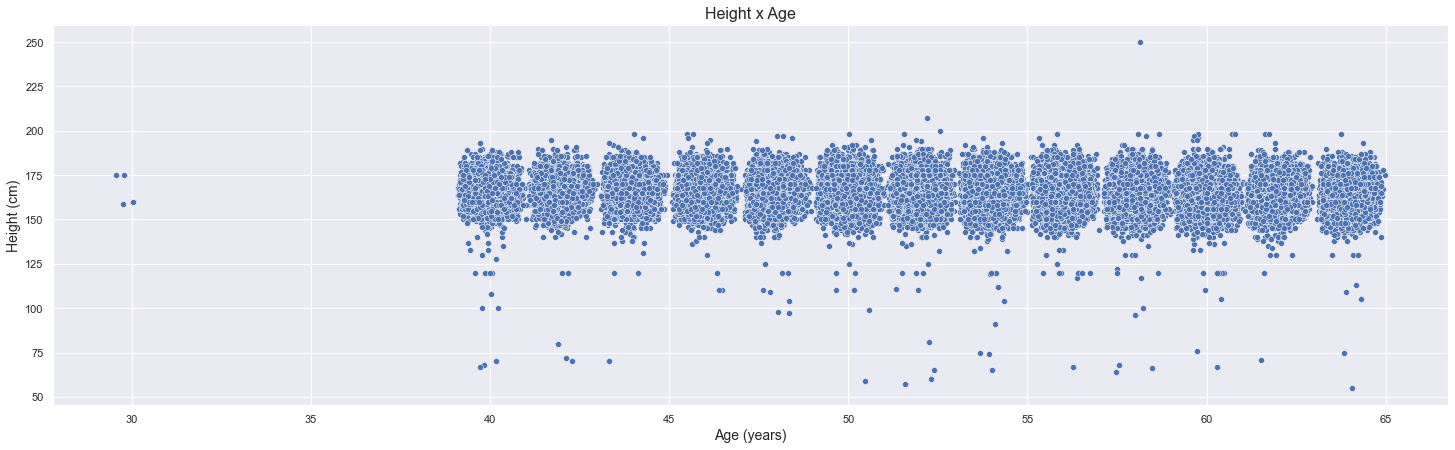

In [26]:
sns.set(rc={'figure.figsize':(25,7)})

sns.scatterplot(x='age_years', y='height', data=df1, palette = 'winter')
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Height (cm)", fontsize=14)
plt.title("Height x Age", fontsize=16)

Points in **height**: x <= 110 cm  or  210 cm <= x, will be considered outliers.

Text(0.5, 1.0, 'Diastolic x Systolic')

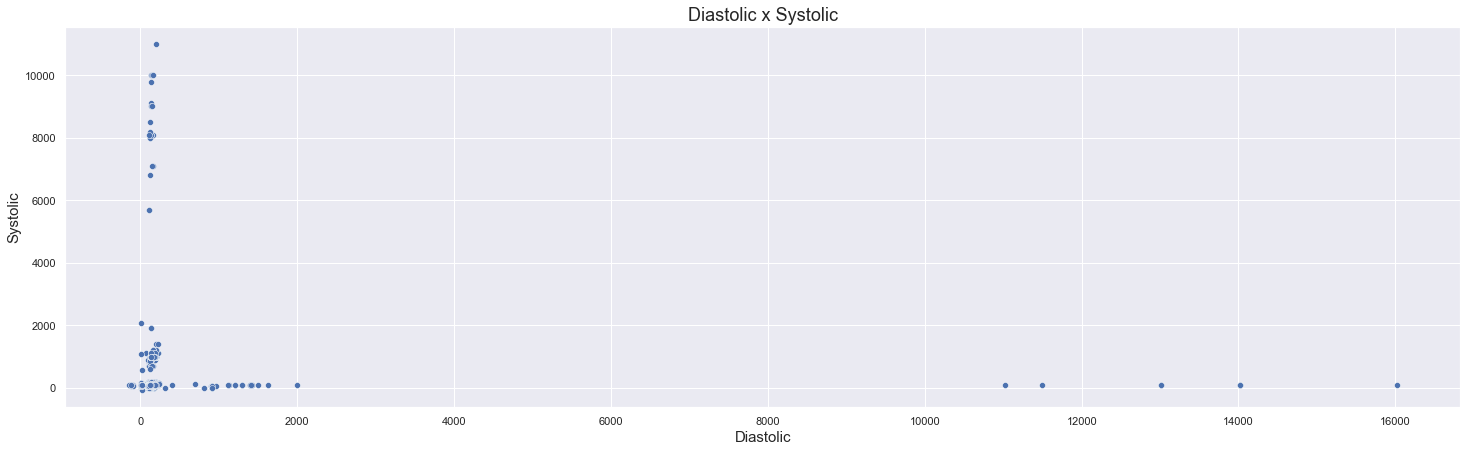

In [27]:
sns.set(rc={'figure.figsize':(25,7)})

sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', data=df1)
plt.xlabel("Diastolic", fontsize=15)
plt.ylabel("Systolic", fontsize=15)
plt.title("Diastolic x Systolic", fontsize=18)

Points up to 210 for Diastolic and Systolic blood pressure, will be considered outliers.

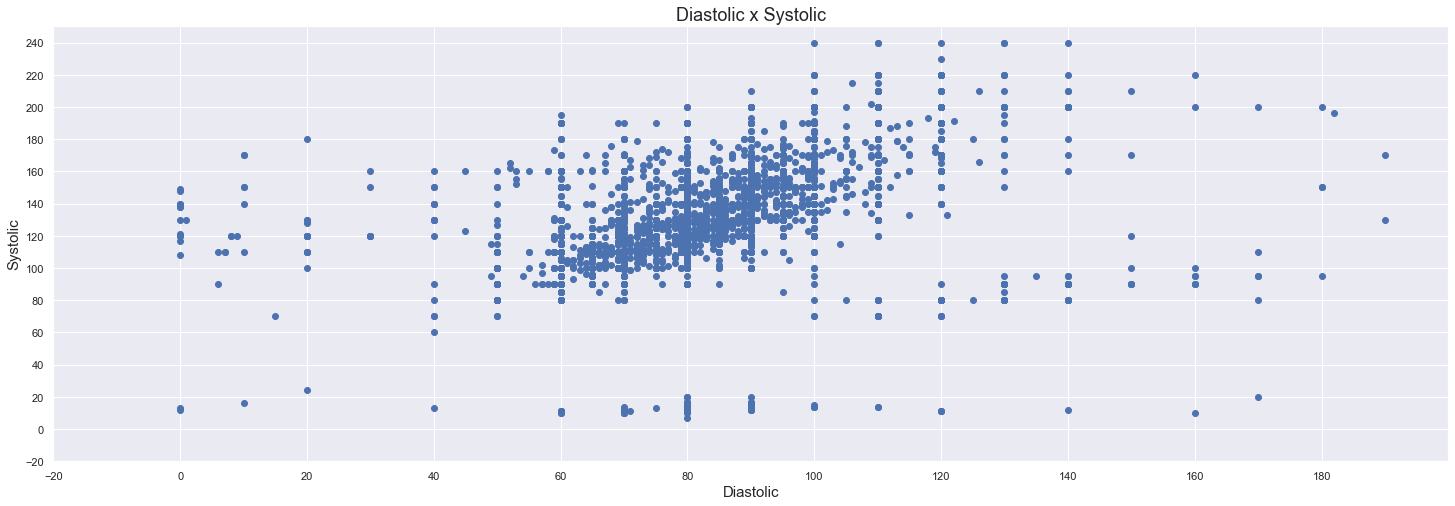

In [28]:
fig, ax = plt.subplots(figsize=(25,8))

plt.scatter(df1['diastolic_blood_pressure'],df1['systolic_blood_pressure'])
plt.xlabel("Diastolic", fontsize=15)
plt.ylabel("Systolic", fontsize=15)
plt.title("Diastolic x Systolic", fontsize=18)
start, end = ax.set_xlim([-20,200])
ax.xaxis.set_ticks(np.arange(start, end, 20))
start, end = ax.set_ylim([-20,250])
ax.yaxis.set_ticks(np.arange(start, end, 20))
ax.grid(True)

Points lower than 40 for Diastolic and 60 for Systolic blood pressure, will be considered outliers.

### 1.8.2 Removing Outliers

In [29]:
# removing outliers: blood pressure
df_new = df1[~((df1['systolic_blood_pressure'] > 210) | (df1['diastolic_blood_pressure'] > 150) 
           | (df1['systolic_blood_pressure'] < 60) | (df1['diastolic_blood_pressure'] < 40))]

# removing outliers: height
df_new = df_new[~((df_new['height'] <= 110) | (df_new['height'] >= 210))]

# removing outliers: weight
df_new = df_new[~(df_new['weight'] <= 40)]

# removing outliers: age
df_new = df_new[~(df_new['age_years'] < 35)]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68587 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        68587 non-null  int64  
 1   age                       68587 non-null  int64  
 2   gender                    68587 non-null  object 
 3   height                    68587 non-null  int64  
 4   weight                    68587 non-null  int32  
 5   systolic_blood_pressure   68587 non-null  int64  
 6   diastolic_blood_pressure  68587 non-null  int64  
 7   cholesterol               68587 non-null  object 
 8   glucose                   68587 non-null  object 
 9   smoking                   68587 non-null  int64  
 10  alcohol                   68587 non-null  int64  
 11  physical_activity         68587 non-null  int64  
 12  cardio_disease            68587 non-null  int64  
 13  age_years                 68587 non-null  float64
 14  age_gr

In [30]:
ratio_of_outliers_removed = 100 - (df_new.shape[0] / df1.shape[0]) * 100
print(f'Ratio of removed outliers: {round(ratio_of_outliers_removed, 2)}%')

Ratio of removed outliers: 2.02%


### 1.8.3 Exporting Data

In [31]:
df_new.to_csv('data/clean_data.csv', index=False)

# 2.0  FEATURE ENGENEERING

In [32]:
df2 = df_new.copy()

## 2.1 Mind Map Hypotheses

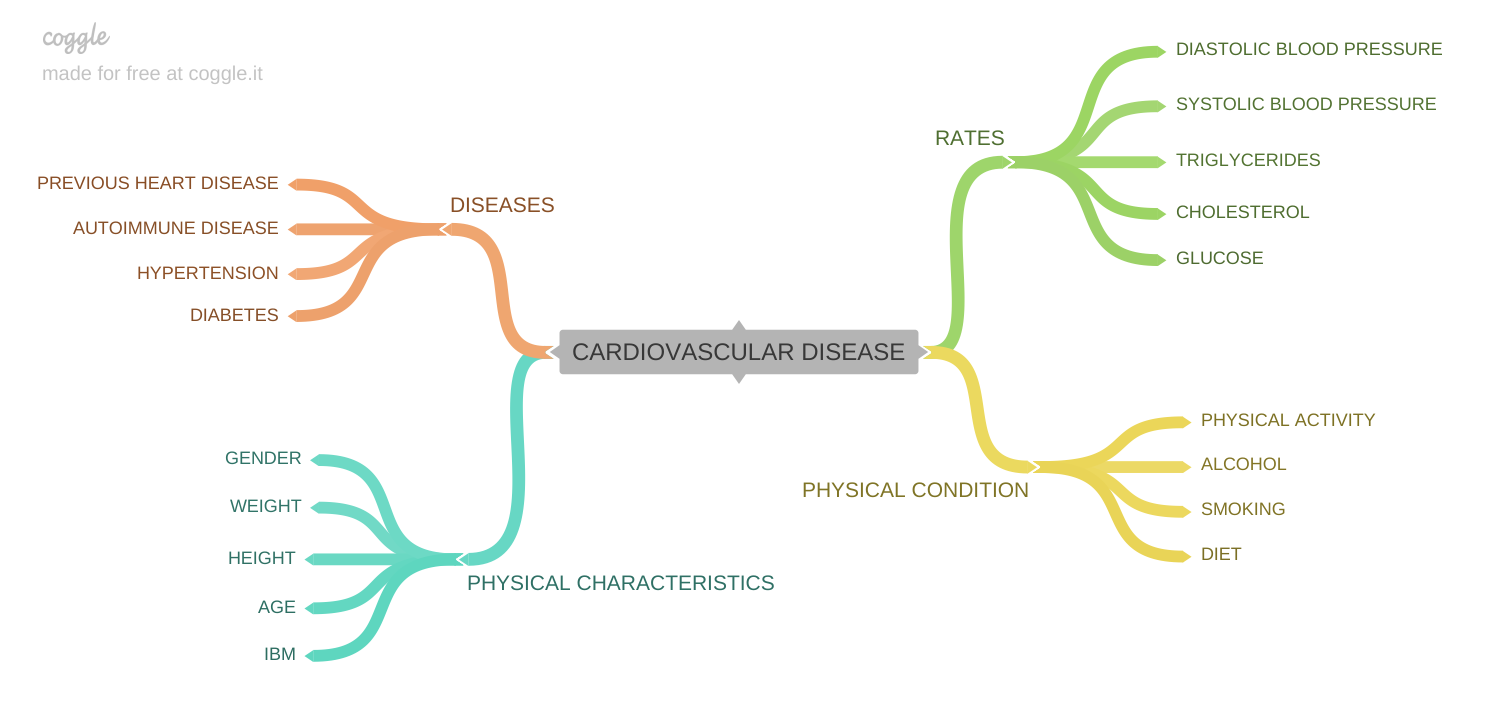

In [33]:
Image ('img/CARDIOVASCULAR_DISEASE.png')

## 2.2 Hypotheses criation

### 2.2.1 Diseases Hypotheses

**1.** People with a previous heart disease should have more cardio disease.

**2.** People with a family history of heart disease should have more cardio disease.

**3.** People with autoimmune diseases should have more cardio disease.

**4.** People with hipertension should have more cardio disease.

**5.** People with diabetes should have more cardio disease.

**6.** People with psychological illnesses like anxiety and depression should have more cardio disease.

### 2.2.2 Rates Hypotheses

**1.** People with systolic blood pressure higher then 140 should have more cardio disease.

**2.** People with systolic blood pressure lower then 90 should have more cardio disease.

**3.** People with diastolic blood pressure higher then 90 should have more cardio disease.

**4.** People with diastolic blood pressure lower then 60 should have more cardio disease.

**5.** People with triglycerides higher then 200mg/dL should have more cardio disease.

**6.** People with higher cholesterol should have more cardio disease.

**7.** People with glucose (fasting) higher then 125mg/dL should have more cardio disease.

### 2.2.3 Physical Characteristics Hypotheses

**1.** Men should have more cardio disease then women.

**2.** Obese people should have more cardio disease.

**3.** Height should not interfere with the likelihood of cardio disease.

**4.** Elderly people should have more cardio disease.

### 2.2.4 Physical Condition Hypotheses

**1.** People who practice physical activities should have less cardio disease.

**2.** People who drink should have more cardio disease.

**3.** People who smoke should have more cardio disease.

**4.** People who eat healthily should have less cardio disease.

## 2.3 Hypotheses final list

**1.** People with hipertension should have more cardio disease.

**2.** People with diabetes should have more cardio disease.


**3.** People with systolic blood pressure higher then 140 should have more cardio disease.

**4.** People with systolic blood pressure lower then 90 should have more cardio disease.

**5.** People with diastolic blood pressure higher then 90 should have more cardio disease.

**6.** People with diastolic blood pressure lower then 60 should have more cardio disease.

**7.** People with higher cholesterol should have more cardio disease.


**8.** Men should have more cardio disease then women.

**9.** Obese people should have more cardio disease.

**10.** Height should not interfere with the likelihood of cardio disease.

**11.** Elderly people should have more cardio disease.


**12.** People who practice physical activities should have less cardio disease.

**13.** People who smoke should have more cardio disease.

## 2.4 Hypotheses for Future Analysis

**1.** People with a previous heart disease should have more cardio disease.

**2.** People with a family history of heart disease should have more cardio disease.

**3.** People with autoimmune diseases should have more cardio disease.

**4.** People with psychological illnesses like anxiety and depression should have more cardio disease.

**5.** People with triglycerides higher then 200mg/dL should have more cardio disease.

**6.** People with glucose (fasting) higher then 125mg/dL should have more cardio disease.

**7.** People who drink should have more cardio disease.

**8.** People who eat healthily should have less cardio disease.

## 2.5 Feature Engeneering

In [34]:
df2["BMI"] = df2[["height", "weight"]].apply(lambda x: calcBMI(x["weight"], x["height"]/100), axis=1)
df2["weight_status"] = df2["BMI"].apply(BMI)

In [35]:
df2['blood_pressure_stage'] = df2.apply( lambda x: 'hypertensive crisis' if (x['systolic_blood_pressure'] > 180) | (x['diastolic_blood_pressure'] > 120) 
                                        else 'high (stage 2)' if ((x['systolic_blood_pressure'] >= 140) & (x['systolic_blood_pressure'] <= 180)) | 
                                        ((x['diastolic_blood_pressure'] >= 90) & (x['diastolic_blood_pressure'] <= 120))
                                        else 'high (stage 1)' if ((x['systolic_blood_pressure'] >= 130) & (x['systolic_blood_pressure'] <= 139)) | 
                                        ((x['diastolic_blood_pressure'] >= 80) & (x['diastolic_blood_pressure'] <= 89))
                                        else 'elevated' if ((x['systolic_blood_pressure'] >= 120) & (x['systolic_blood_pressure'] <= 129)) & 
                                        (x['diastolic_blood_pressure'] < 80)
                                        else 'normal' if ((x['systolic_blood_pressure'] > 90) & (x['systolic_blood_pressure'] < 120)) & 
                                        ((x['diastolic_blood_pressure'] > 60) & (x['diastolic_blood_pressure'] < 80))
                                        else 'low' , axis = 1)           

In [36]:
df2.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years,age_group,BMI,weight_status,blood_pressure_stage
0,0,18393,women,168,62,110,80,normal,normal,0,0,1,0,50.39000,more then 50,22.00000,Healthy,high (stage 1)
1,1,20228,men,156,85,140,90,well above normal,normal,0,0,1,1,55.42000,more then 50,34.90000,Obese,high (stage 2)
2,2,18857,men,165,64,130,70,well above normal,normal,0,0,0,1,51.66000,more then 50,23.50000,Healthy,high (stage 1)
3,3,17623,women,169,82,150,100,normal,normal,0,0,1,1,48.28000,40-50,28.70000,Overweight,high (stage 2)
4,4,17474,men,156,56,100,60,normal,normal,0,0,0,0,47.87000,40-50,23.00000,Healthy,low


# 3.0 VARIABLE FILTERING

In [37]:
df3 = df2.copy()

## 3.1 Line Filtering

<AxesSubplot:xlabel='BMI', ylabel='Density'>

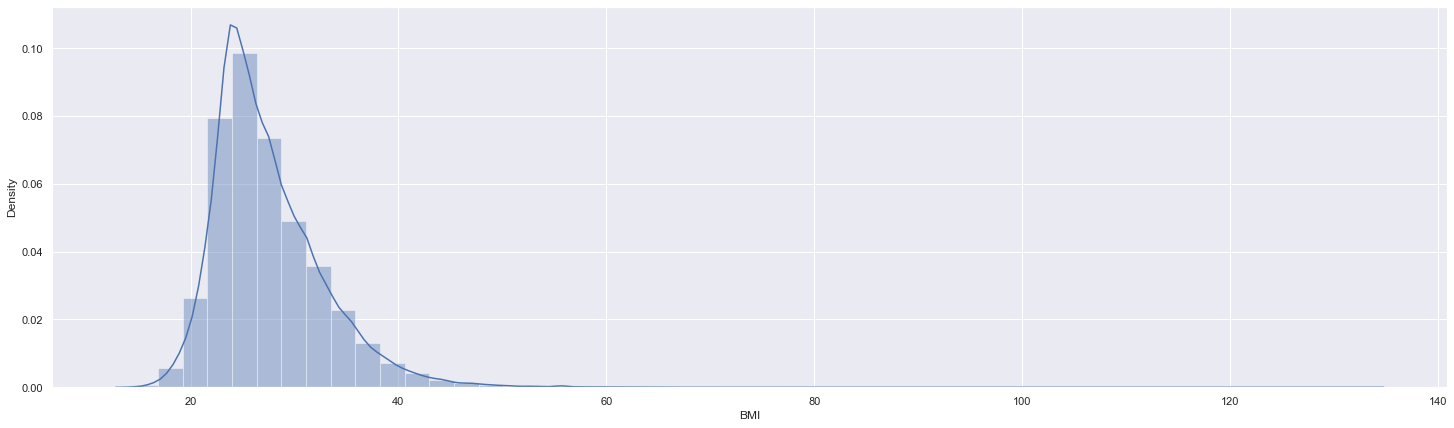

In [38]:
sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(df3['BMI'])

In [39]:
# Removing outliers: BMI
df3 = df3[(df3['BMI'] < 60)]

<AxesSubplot:xlabel='BMI', ylabel='Density'>

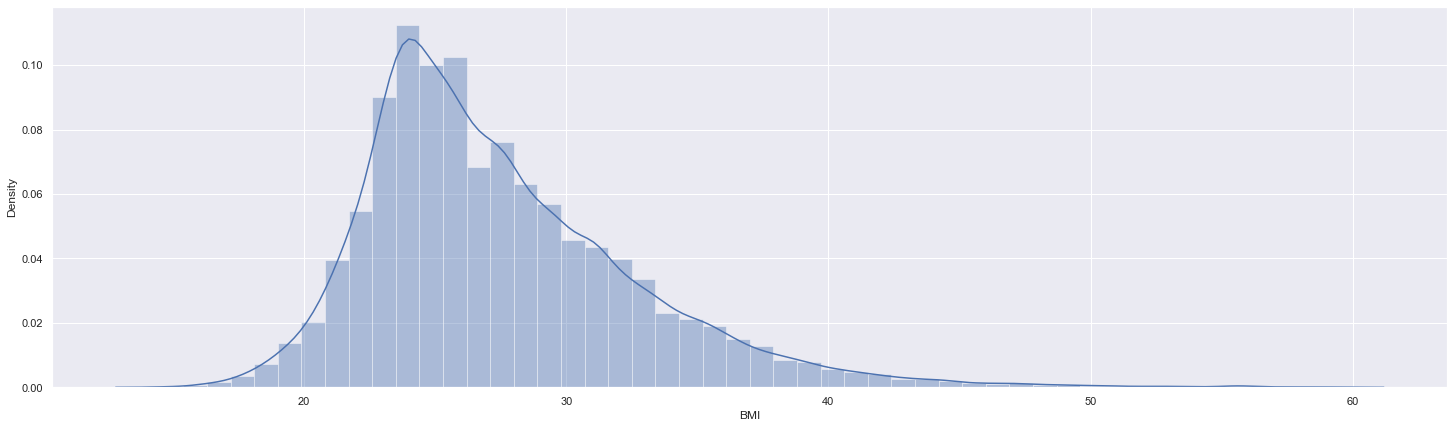

In [40]:
sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(df3['BMI'])

## 3.2 Columns Selection

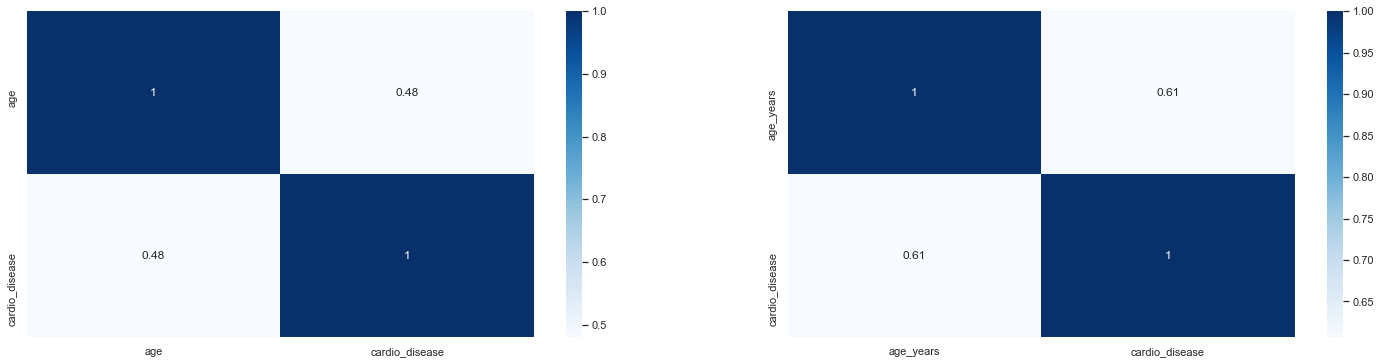

In [41]:
fig = plt.figure(figsize = (25,6))

plt.subplot (1,2,1)
aux1 = df3[['age', 'cardio_disease']].groupby ('age').mean().reset_index()
sns.heatmap(aux1.corr(method= 'pearson'), annot = True,  cmap="Blues");

plt.subplot (1,2,2)
aux2 = df3[['age_years', 'cardio_disease']].groupby ('age_years').mean().reset_index()
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [42]:
cols_drop = ['age']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [43]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='cardio_disease', ylabel='Density'>

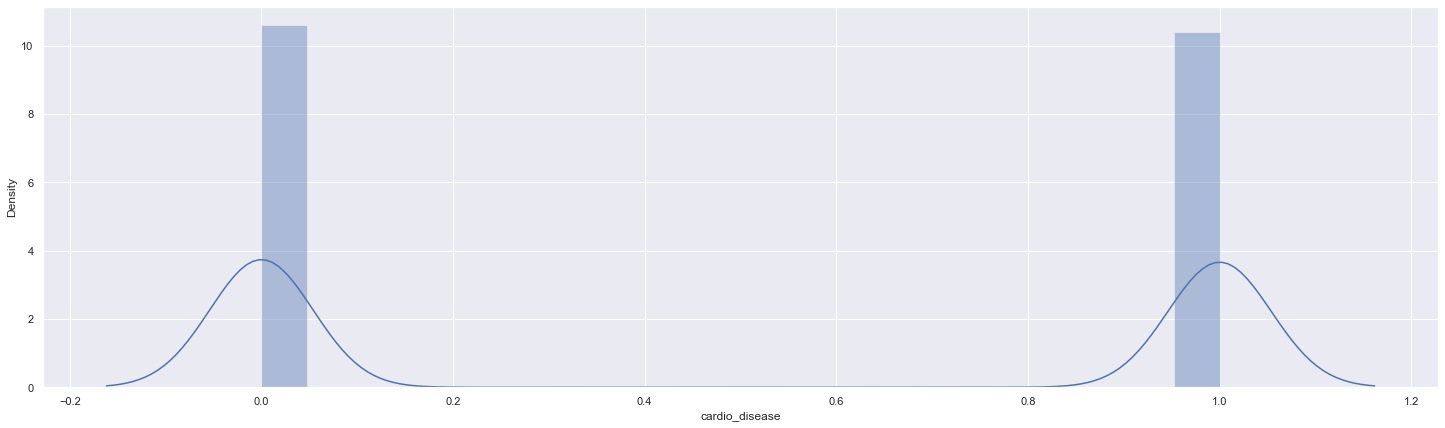

In [44]:
sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(df4['cardio_disease'])

### 4.1.2 Numerical Variable

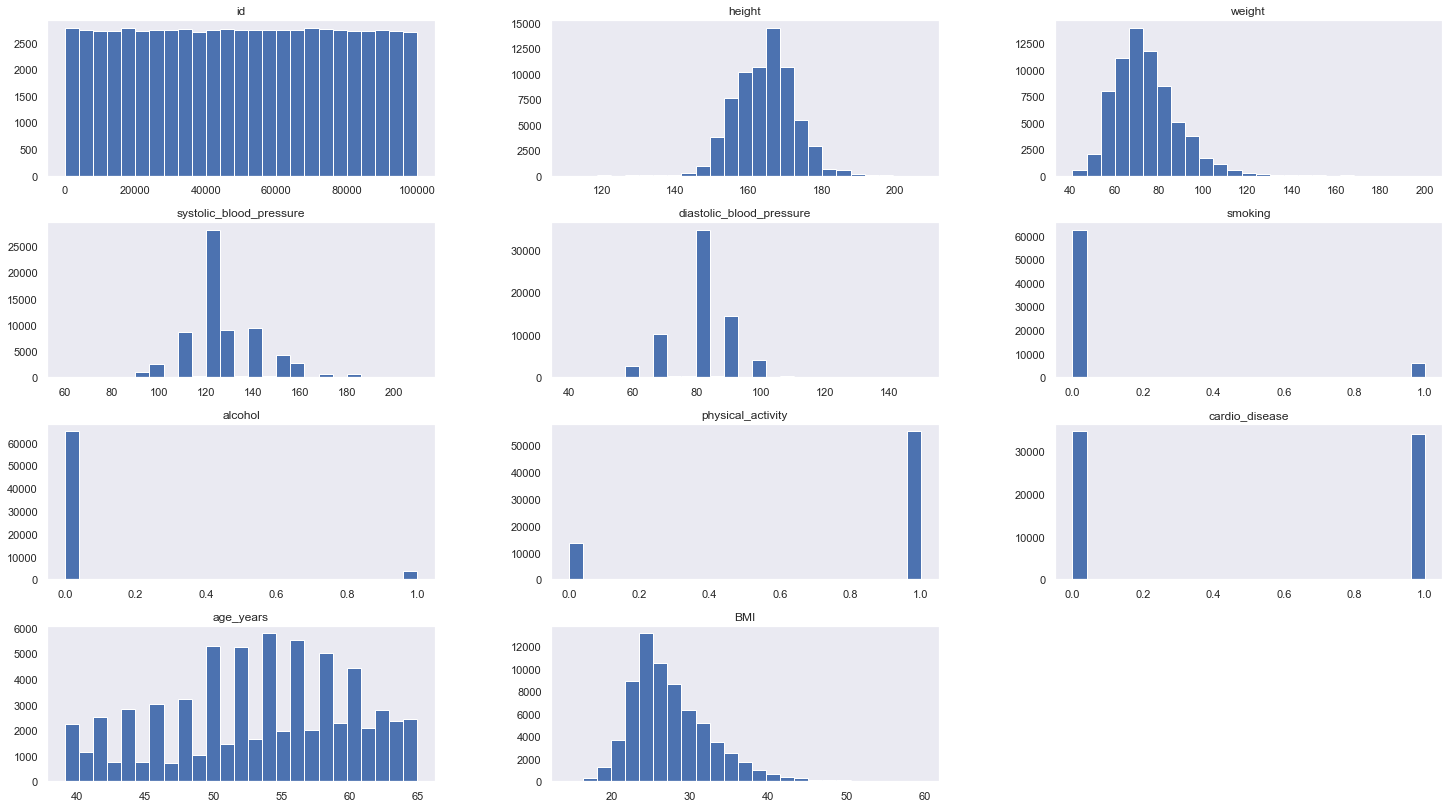

In [45]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

fig = plt.figure(figsize = (25,14))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [46]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00000,99999.00000,99999.00000,49967.24261,50005.50000,28849.03446,-0.00098,-1.19839
1,height,111.00000,207.00000,96.00000,164.43171,165.00000,7.89907,0.02839,0.63579
2,weight,41.00000,200.00000,159.00000,74.12896,72.00000,14.15816,0.96021,2.04329
3,systolic_blood_pressure,60.00000,210.00000,150.00000,126.58626,120.00000,16.61142,0.84399,1.44576
4,diastolic_blood_pressure,40.00000,150.00000,110.00000,81.35000,80.00000,9.52024,0.42154,2.12919
5,smoking,0.00000,1.00000,1.00000,0.08811,0.00000,0.28345,2.90628,6.44663
6,alcohol,0.00000,1.00000,1.00000,0.05357,0.00000,0.22517,3.96532,13.72418
7,physical_activity,0.00000,1.00000,1.00000,0.80326,1.00000,0.39754,-1.52573,0.32785
8,cardio_disease,0.00000,1.00000,1.00000,0.49494,0.00000,0.49997,0.02025,-1.99965
9,age_years,39.11000,64.97000,25.86000,53.32774,53.97000,6.75788,-0.30378,-0.82993


### 4.1.3 Categorical Variable

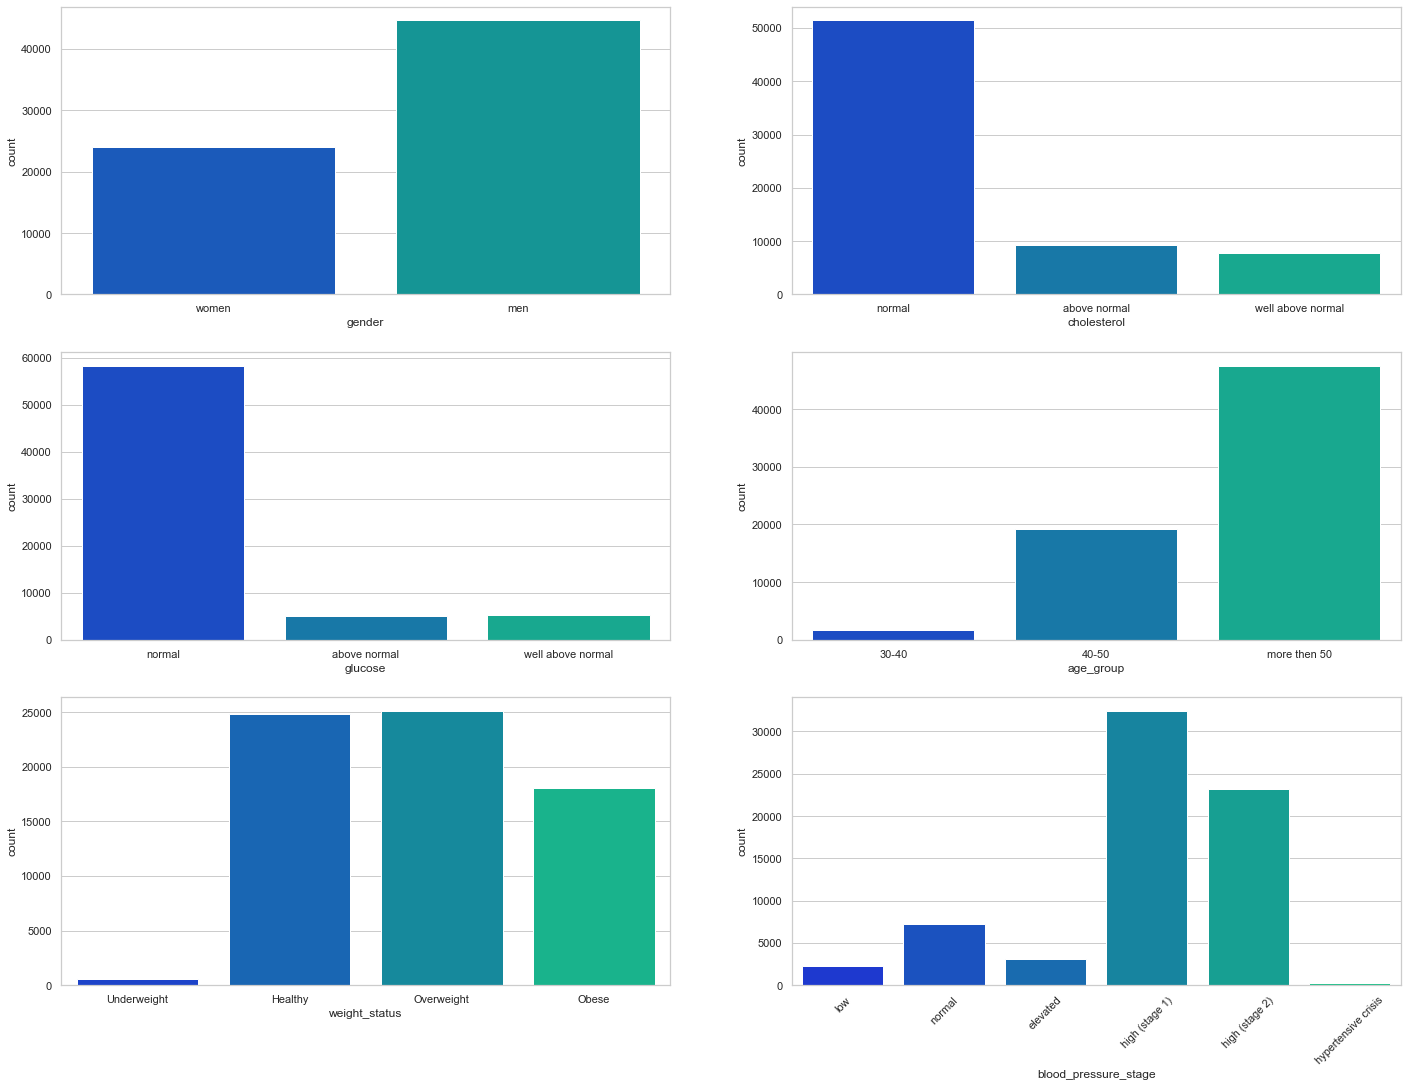

In [47]:
fig = plt.figure(figsize = (24,18))
sns.set_style("whitegrid")
sns.color_palette("winter")

# gender
plt.subplot (3,2,1)
sns.countplot(df4['gender'], palette = 'winter')

# cholesterol
plt.subplot (3,2,2)
sns.countplot(df4['cholesterol'], palette = 'winter', order = ['normal', 'above normal', 'well above normal'])

# glucose
plt.subplot (3,2,3)
sns.countplot(df4['glucose'], palette = 'winter')

# age_group
plt.subplot (3,2,4)
sns.countplot(df4['age_group'], palette = 'winter', order = ['30-40', '40-50', 'more then 50'])

# weight_status
plt.subplot (3,2,5)
sns.countplot(df4['weight_status'], palette = 'winter', order = ['Underweight', 'Healthy', 'Overweight', 'Obese'])

# blood_pressure_stage
plt.subplot (3,2,6)
sns.countplot(df4['blood_pressure_stage'], palette = 'winter', order=["low", "normal", 'elevated', 'high (stage 1)', 'high (stage 2)', 'hypertensive crisis'])
plt.xticks(rotation = 45);

## 4.2 Bivariate Analysis

### H1: People with hipertension should have more cardio disease.
**TRUE.** People with hipertension HAVE MORE cardio disease.

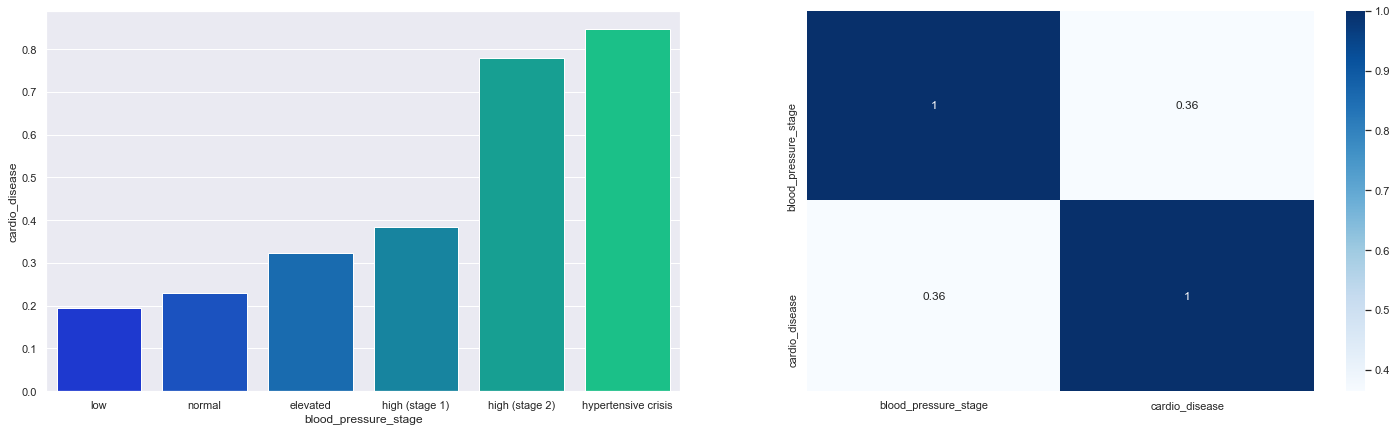

In [48]:
sns.set(rc={'figure.figsize':(25,7)})
plt.subplot (1,2,1)
aux1 = df4[['blood_pressure_stage', 'cardio_disease']].groupby('blood_pressure_stage').mean().reset_index()
sns.barplot (x = 'blood_pressure_stage', y = 'cardio_disease', data = aux1, palette = 'winter', order=["low", "normal", 'elevated', 'high (stage 1)', 'high (stage 2)', 'hypertensive crisis']);

aux2 = df4[['blood_pressure_stage', 'cardio_disease']]
aux2['blood_pressure_stage'] = aux2['blood_pressure_stage'].apply( lambda x: 1 if x == 'low' else 2 if x == 'normal' else 3 if x == 'elevated' else 4 if x == 'high (stage 1)' else 5 if x == 'high (stage 2)' else 6 )
plt.subplot (1,2,2)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [49]:
cardio_table(df4,'blood_pressure_stage')

,blood_pressure_stage,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,elevated,1004,3105,32.33000,4.53000
1,high (stage 1),12471,32406,38.48000,47.27000
2,high (stage 2),18100,23251,77.85000,33.91000
3,hypertensive crisis,256,302,84.77000,0.44000
4,low,446,2297,19.42000,3.35000
5,normal,1657,7201,23.01000,10.50000


### H2: People with diabetes should have more cardio disease.
**TRUE.** People with diabetes HAVE MORE cardio disease.

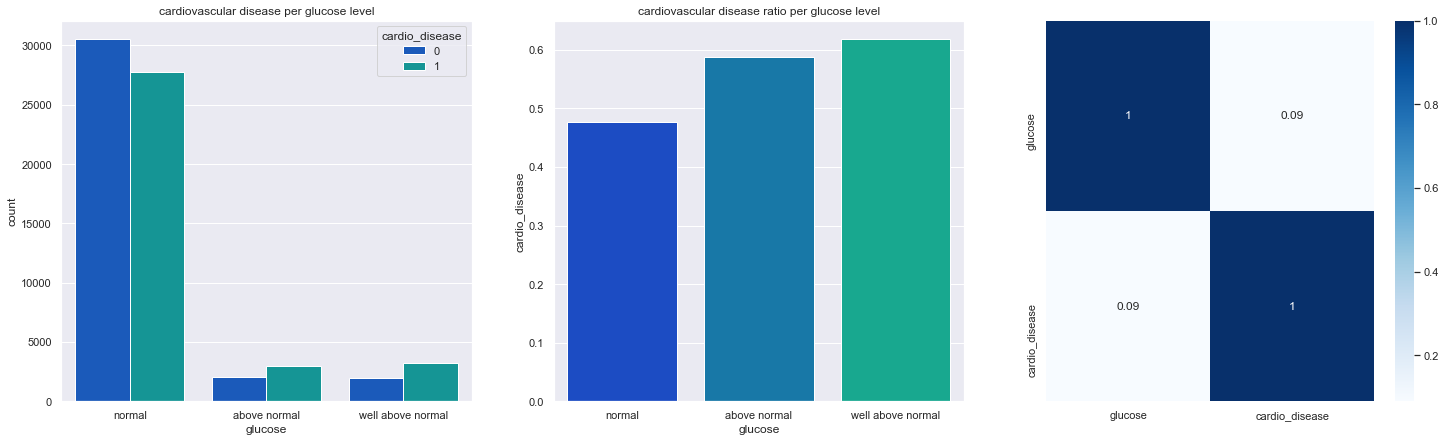

In [50]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['glucose', 'cardio_disease']].groupby('glucose').mean().reset_index()

plt.subplot(1, 3, 1)
sns.countplot(x='glucose', hue='cardio_disease', data=df4, palette = 'winter').set_title('cardiovascular disease per glucose level');

plt.subplot(1, 3, 2)
sns.barplot (x = 'glucose', y = 'cardio_disease', data = aux1,palette = 'winter', order = ['normal', 'above normal', 'well above normal']).set_title('cardiovascular disease ratio per glucose level');

aux2 = df4[['glucose', 'cardio_disease']]
aux2['glucose'] = aux2['glucose'].apply( lambda x: 1 if x == 'normal' else 2 if x == 'above normal' else 3)
plt.subplot (1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [51]:
cardio_table(df4,'glucose')

,glucose,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,above normal,2975,5058,58.82000,7.38000
1,normal,27732,58286,47.58000,85.01000
2,well above normal,3227,5218,61.84000,7.61000


### H3: People with systolic blood pressure higher then 140 should have more cardio disease.
**TRUE.** People with systolic blood pressure higher then 140 HAVE MORE cardio disease.

<AxesSubplot:>

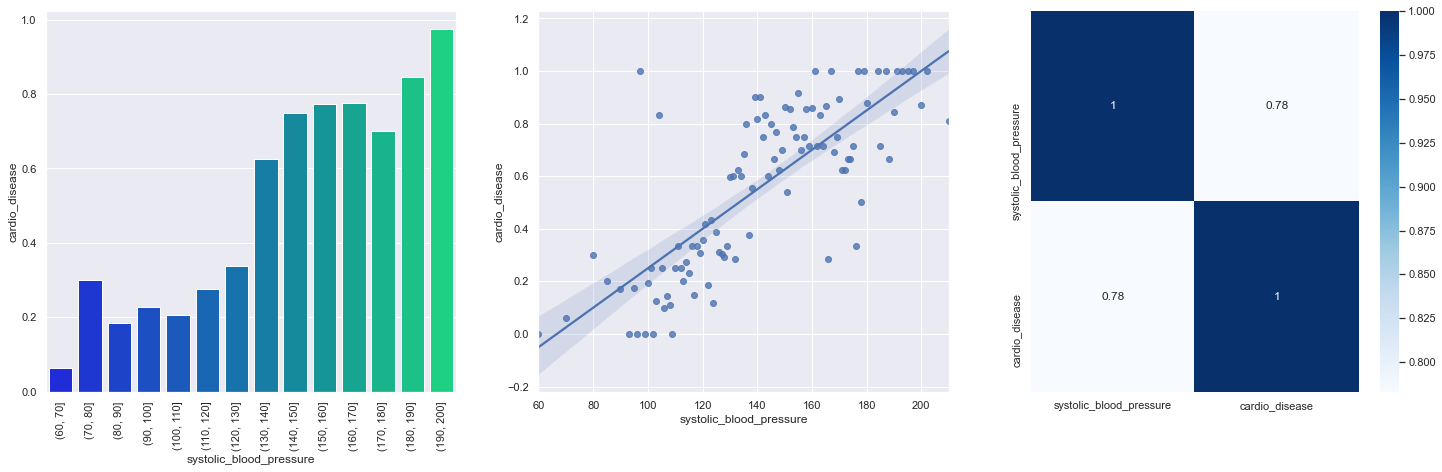

In [52]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()

plt.subplot (1,3,1)
bins = list(np.arange(60, 210, 10))
aux1['systolic_blood_pressure'] = pd.cut (aux1['systolic_blood_pressure'], bins = bins)
aux2 = aux1[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

plt.subplot (1,3,2)
aux3 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.regplot(x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="Blues")

### H4: People with systolic blood pressure lower then 90 should have more cardio disease.
**FALSE.**  People with systolic blood pressure lower then 90 HAVE LESS cardio disease.

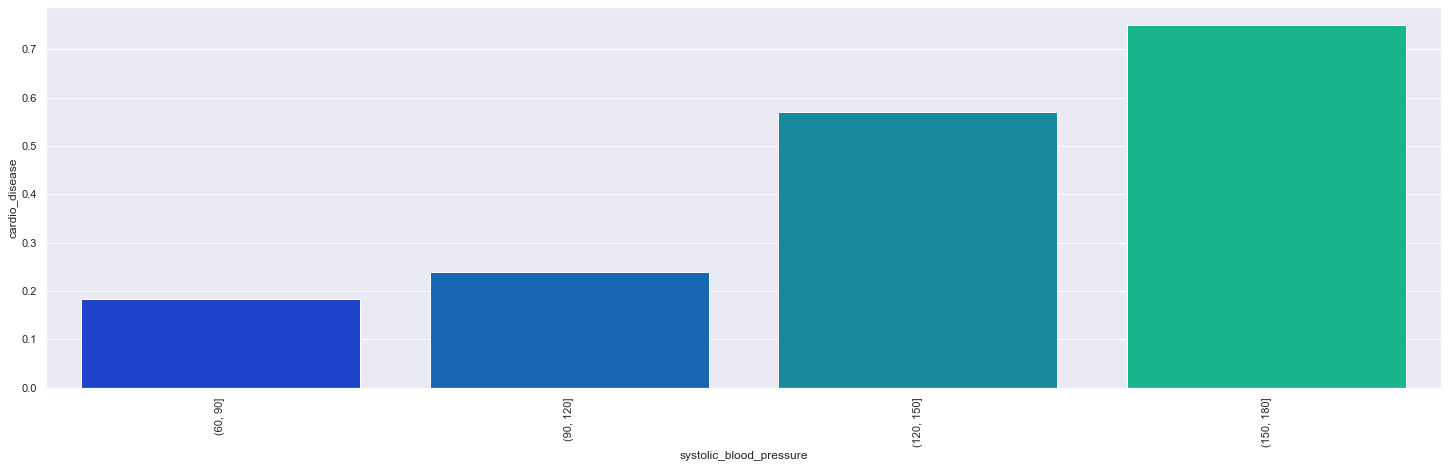

In [53]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()

bins = list(np.arange(60, 210, 30))
aux1['systolic_blood_pressure'] = pd.cut (aux1['systolic_blood_pressure'], bins = bins)
aux2 = aux1[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

### H5: People with diastolic blood pressure higher then 90 should have more cardio disease.
**TRUE.** People with diastolic blood pressure higher then 90 HAVE MORE cardio disease.

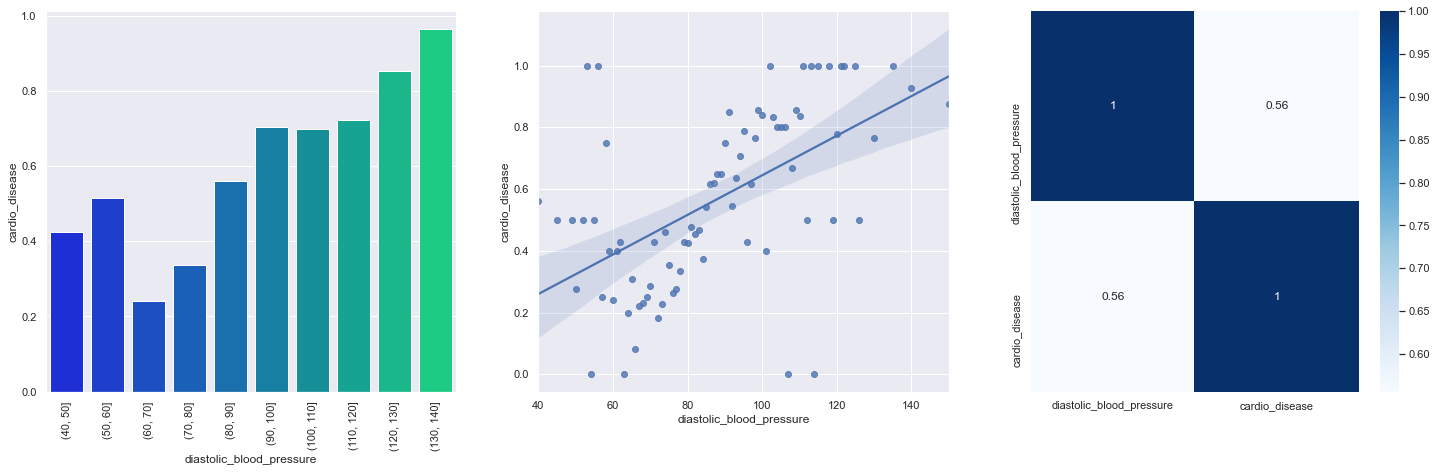

In [54]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()

plt.subplot (1,3,1)
bins = list(np.arange(40, 150, 10))
aux1['diastolic_blood_pressure'] = pd.cut (aux1['diastolic_blood_pressure'], bins = bins)
aux2 = aux1[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

plt.subplot (1,3,2)
aux3 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.regplot(x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="Blues");

### H6: People with diastolic blood pressure lower then 60 should have more cardio disease.
**TRUE.** People with diastolic blood pressure lower then 60 HAVE MORE cardio disease THEN people with 60-80 diastolic blood pressure.

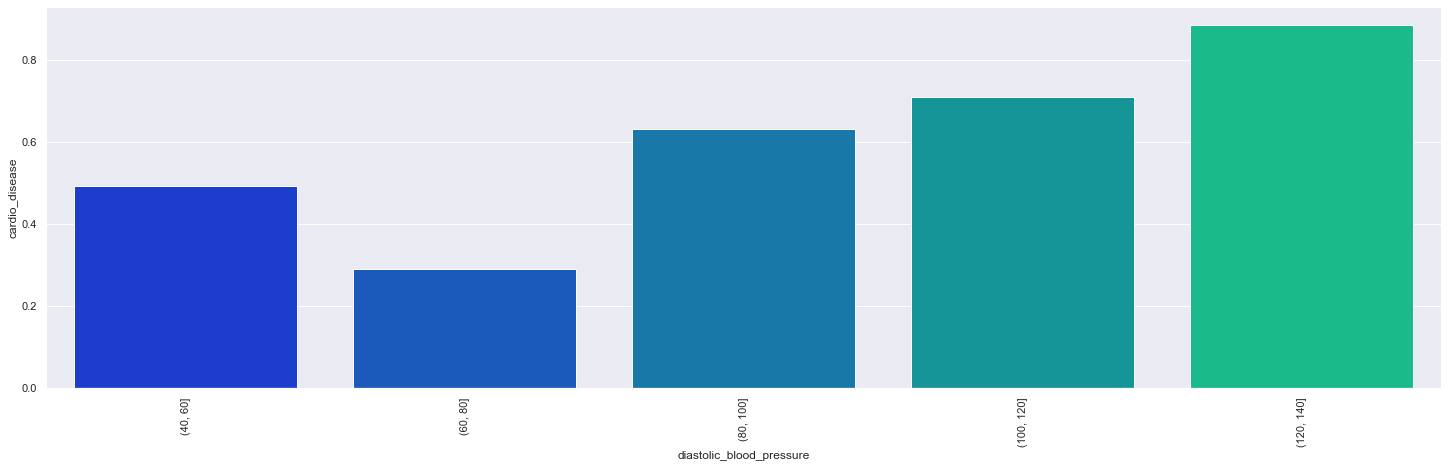

In [55]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()

bins = list(np.arange(40, 150, 20))
aux1['diastolic_blood_pressure'] = pd.cut (aux1['diastolic_blood_pressure'], bins = bins)
aux2 = aux1[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

### H7: People with higher cholesterol should have more cardio disease.
**TRUE.** People with higher cholesterol HAVE MORE cardio disease.

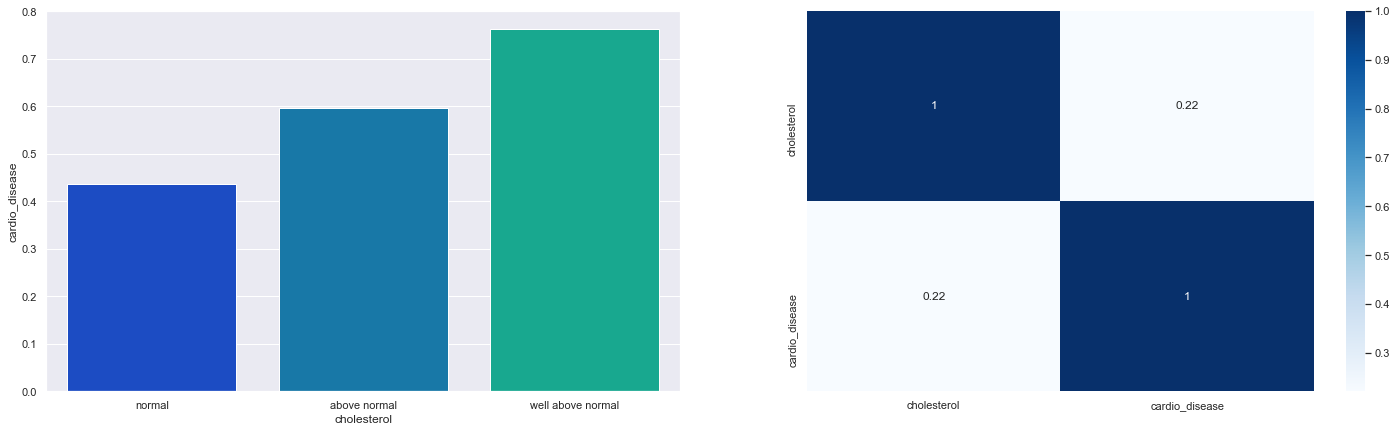

In [56]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['cholesterol', 'cardio_disease']].groupby('cholesterol').mean().reset_index()
plt.subplot (1,2,1)
sns.barplot (x = 'cholesterol', y = 'cardio_disease', data = aux1, palette = 'winter', order = ['normal', 'above normal', 'well above normal']);

aux2 = df4[['cholesterol', 'cardio_disease']]
aux2['cholesterol'] = aux2['cholesterol'].apply( lambda x: 1 if x == 'normal' else 2 if x == 'above normal' else 3)
plt.subplot (1,2,2)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [57]:
cardio_table(df4,'cholesterol')

,cholesterol,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,above normal,5533,9280,59.62000,13.54000
1,normal,22404,51421,43.57000,75.00000
2,well above normal,5997,7861,76.29000,11.47000


### H8: Men should have more cardio disease then women.
**FALSE.** Men suffer a little LESS heart disease than women. 

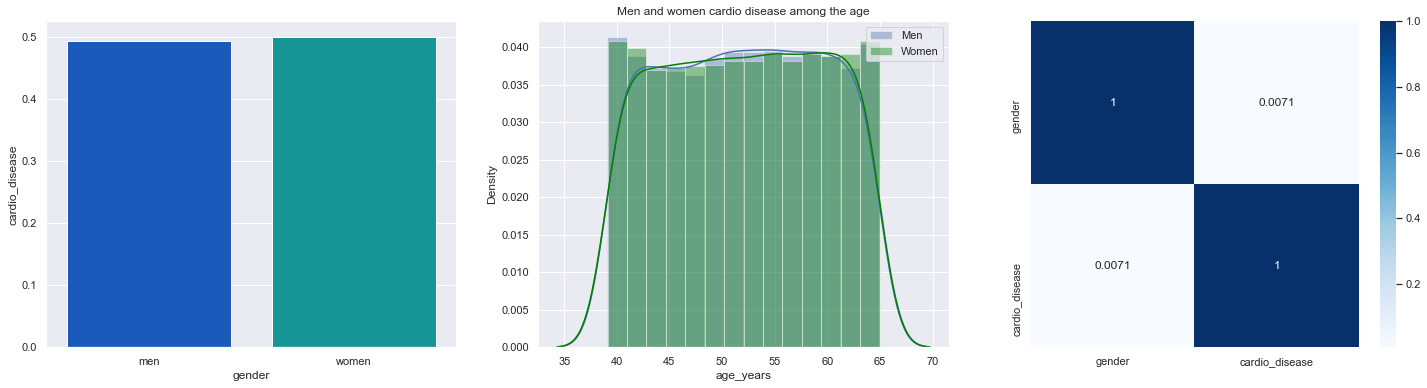

In [58]:
plt.subplots(figsize=(25,6))

plt.subplot (1,3,1)
aux1 = df4[['gender', 'cardio_disease']].groupby('gender').mean().reset_index()
sns.barplot (x = 'gender', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,3,2)
aux2 = df4[df4['gender'] == 'men'][['age_years','cardio_disease']].groupby('age_years').mean().reset_index()
aux3 = df4[df4['gender'] == 'women'][['age_years','cardio_disease']].groupby('age_years').mean().reset_index()

sns.distplot(aux2['age_years'], label='Men');
sns.distplot(aux3['age_years'], color='green', label='Women');
plt.title('Men and women cardio disease among the age');
plt.legend();

aux4 = df4[['gender', 'cardio_disease']]
aux4['gender'] = aux4['gender'].apply( lambda x: 1 if x == 'women' else 0)
plt.subplot (1,3,3)
sns.heatmap(aux4.corr(method= 'pearson'), annot = True, cmap="Blues");

In [59]:
cardio_table(df4,'gender')

,gender,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,men,21972,44629,49.23000,65.09000
1,women,11962,23933,49.98000,34.91000


### H9: Obese people should have more cardio disease.
**TRUE.**  Obese people HAVE MORE cardio disease.

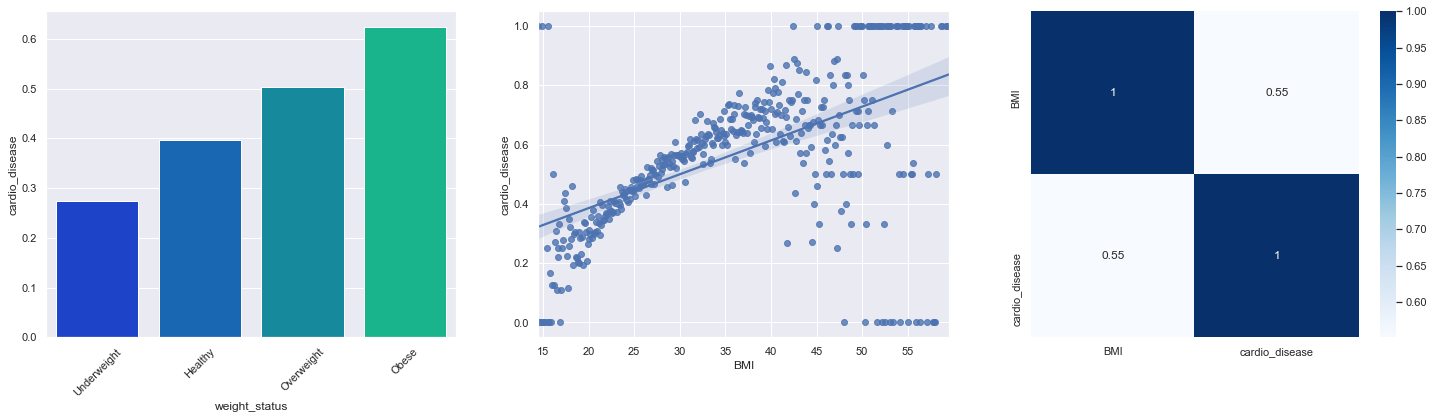

In [60]:
plt.subplots(figsize=(25,6))

plt.subplot (1,3,1)
aux1 = df4[['weight_status', 'cardio_disease']].groupby('weight_status').mean().reset_index()
sns.barplot (x = 'weight_status', y = 'cardio_disease', data = aux1, palette = 'winter', order = ['Underweight', 'Healthy', 'Overweight', 'Obese']);
plt.xticks(rotation = 45);

plt.subplot (1,3,2)
aux2 = df4[['BMI', 'cardio_disease']].groupby('BMI').mean().reset_index()
sns.regplot(x = 'BMI', y = 'cardio_disease', data = aux2);

plt.subplot (1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [61]:
cardio_table(df4,'weight_status')

,weight_status,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,Healthy,9860,24863,39.66000,36.26000
1,Obese,11269,18047,62.44000,26.32000
2,Overweight,12655,25103,50.41000,36.61000
3,Underweight,150,549,27.32000,0.80000


### H10: Height should not interfere with the likelihood of cardio disease.
**TRUE.** Height DON'T INTERFERE with the likelihood of cardio disease.

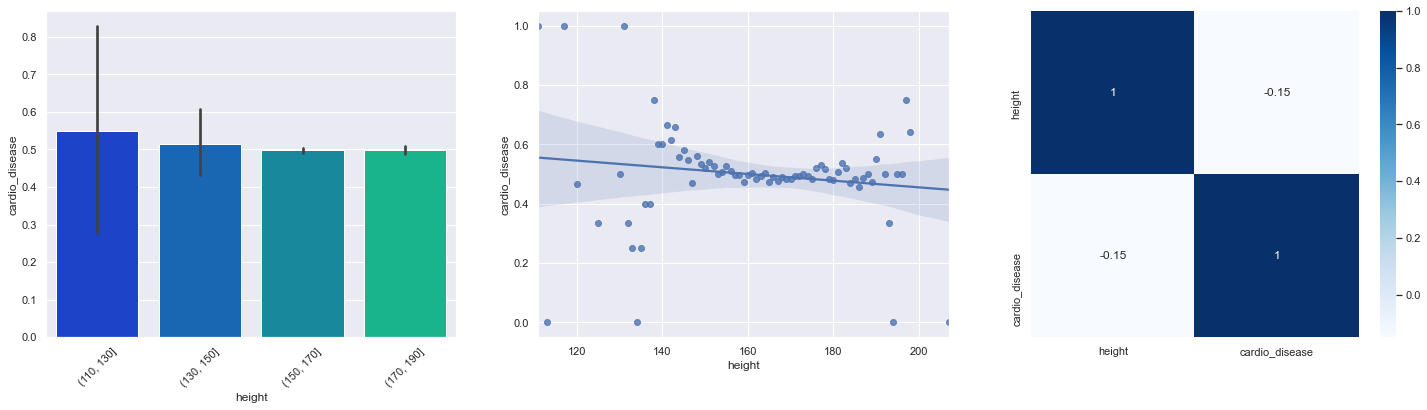

In [62]:
plt.subplots(figsize=(25,6))

plt.subplot (1,3,1)
aux1 = df4[['height', 'cardio_disease']].groupby('height').mean().reset_index()
bins = list(np.arange(110, 210, 20))
aux1['height'] = pd.cut (aux1['height'], bins = bins)
aux2 = aux1[['height', 'cardio_disease']].groupby('height').mean().reset_index()
sns.barplot (x = 'height', y = 'cardio_disease', data = aux1, palette = 'winter');
plt.xticks(rotation = 45);

plt.subplot (1,3,2)
aux3 = df4[['height', 'cardio_disease']].groupby('height').mean().reset_index()
sns.regplot(x = 'height', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="Blues");

### H11: Elderly people should have more cardio disease.
**TRUE.** Elderly people HAVE MORE cardio disease.

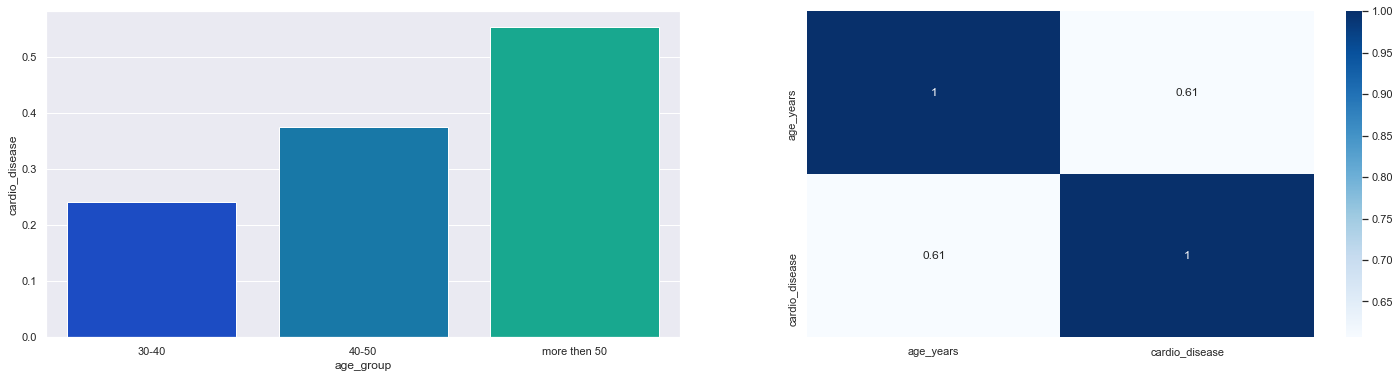

In [63]:
plt.subplots(figsize=(25,6))

plt.subplot (1,2,1)
aux1 = df4[['age_group', 'cardio_disease']].groupby('age_group').mean().reset_index()
sns.barplot (x = 'age_group', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,2,2)
aux2 = df4[['age_years', 'cardio_disease']].groupby('age_years').mean().reset_index()
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [64]:
cardio_table(df4,'age_group')

,age_group,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,30-40,425,1766,24.07000,2.58000
1,40-50,7221,19288,37.44000,28.13000
2,more then 50,26288,47508,55.33000,69.29000


### H12: People who practice physical activities should have less cardio disease.
**TRUE.** People who practice physical activity REGULARLY HAVE LESS cardio disease.

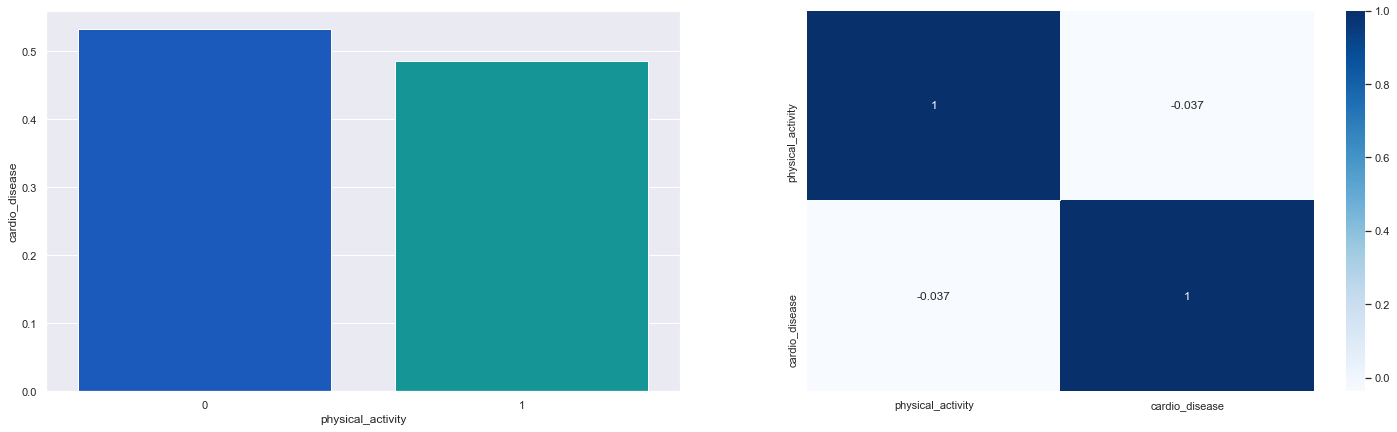

In [65]:
plt.subplots(figsize=(25,7))

plt.subplot (1,2,1)
aux1 = df4[['physical_activity', 'cardio_disease']].groupby('physical_activity').mean().reset_index()
sns.barplot (x = 'physical_activity', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,2,2)
aux2 = df4[['physical_activity', 'cardio_disease']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [66]:
cardio_table(df4,'physical_activity')

,physical_activity,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,0,7185,13489,53.27000,19.67000
1,1,26749,55073,48.57000,80.33000


### H13: People who smoke should have more cardio disease.
**FALSE.** People who smoke HAVE LESS cardio disease.

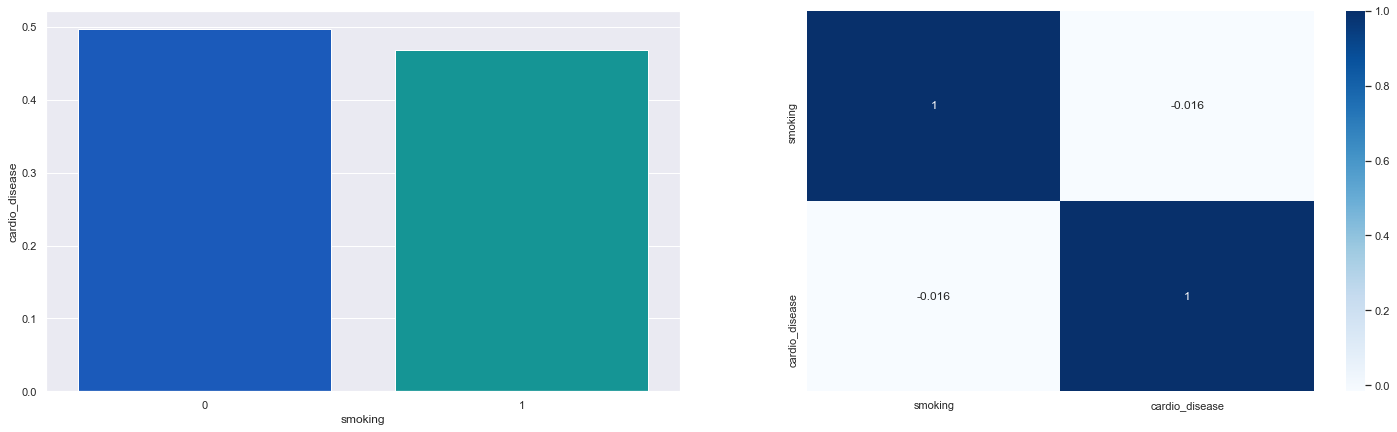

In [67]:
plt.subplot (1,2,1)
aux1 = df4[['smoking', 'cardio_disease']].groupby('smoking').mean().reset_index()
sns.barplot (x = 'smoking', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,2,2)
aux2 = df4[['smoking', 'cardio_disease']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [68]:
cardio_table(df4,'smoking')

,smoking,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,0,31103,62521,49.75000,91.19000
1,1,2831,6041,46.86000,8.81000


### 4.2.1 Hypotheses resume

In [69]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['People with hipertension should have more cardio disease.',
                                      'People with diabetes should have more cardio disease.',
                                      'People with systolic blood pressure higher then 140 should have more cardio disease.',
                                      'People with systolic blood pressure lower then 90 should have more cardio disease.',
                                      'People with diastolic blood pressure higher then 90 should have more cardio disease.',
                                      'People with diastolic blood pressure lower then 60 should have more cardio disease.',
                                      'People with higher cholesterol should have more cardio disease.',
                                      'Men should have more cardio disease then women.',
                                      'Obese people should have more cardio disease.',
                                      'Height should not interfere with the likelihood of cardio disease.',
                                      'Elderly people should have more cardio disease.',
                                      'People who practice physical activities should have less cardio disease.',
                                      'People who smoke should have more cardio disease.',
                                      ],
                        'True / False':['True', 'True', 'True', 'False', 'True', 'True', 'True', 'False', 'True',
                                        'True', 'True','True', 'False'], 
                        'Relevance':['High', 'High', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low', 'Medium', 'Low',
                                     'High','High','High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
summary

,Hypothesis,True / False,Relevance
1,People with hipertension should have more cardio disease.,True,High
2,People with diabetes should have more cardio disease.,True,High
3,People with systolic blood pressure higher then 140 should have more cardio disease.,True,High
4,People with systolic blood pressure lower then 90 should have more cardio disease.,False,Medium
5,People with diastolic blood pressure higher then 90 should have more cardio disease.,True,Medium
6,People with diastolic blood pressure lower then 60 should have more cardio disease.,True,Medium
7,People with higher cholesterol should have more cardio disease.,True,High
8,Men should have more cardio disease then women.,False,Low
9,Obese people should have more cardio disease.,True,Medium
10,Height should not interfere with the likelihood of cardio disease.,True,Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

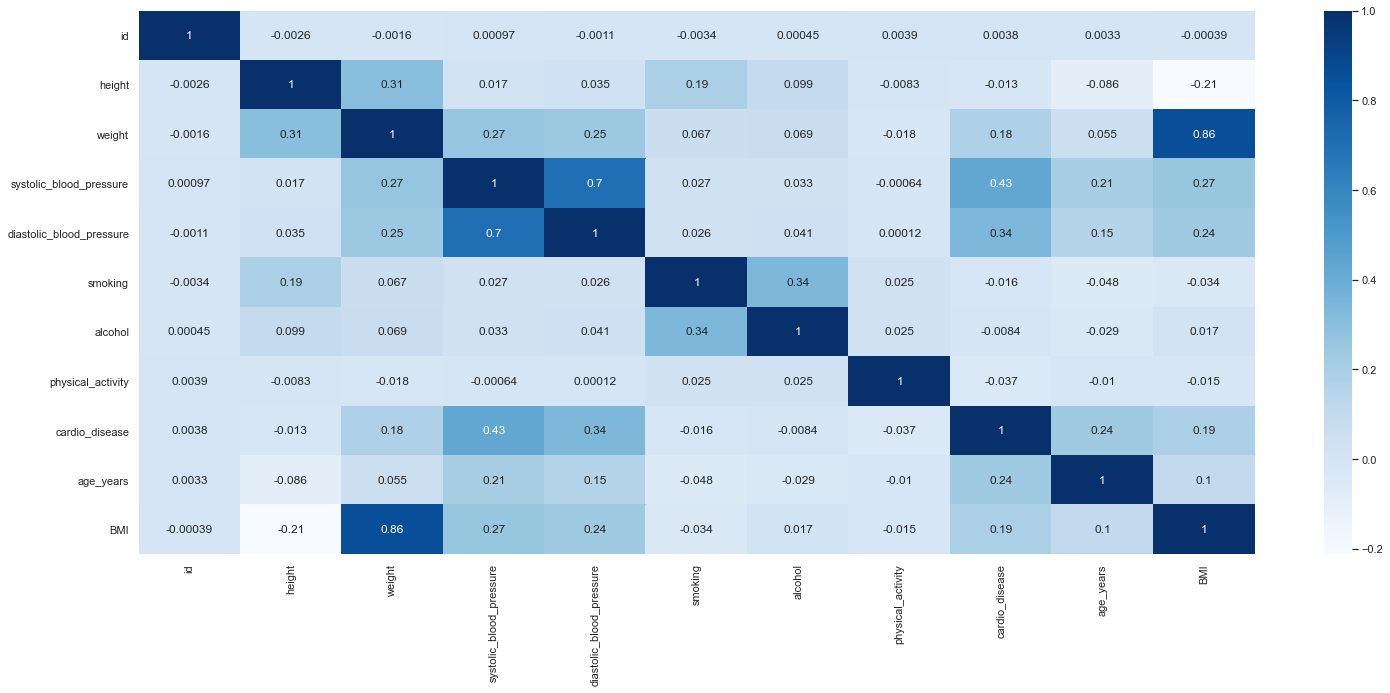

In [70]:
fig = plt.figure(figsize = (25,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, cmap="Blues");

### 4.3.2 Categorical Attributes

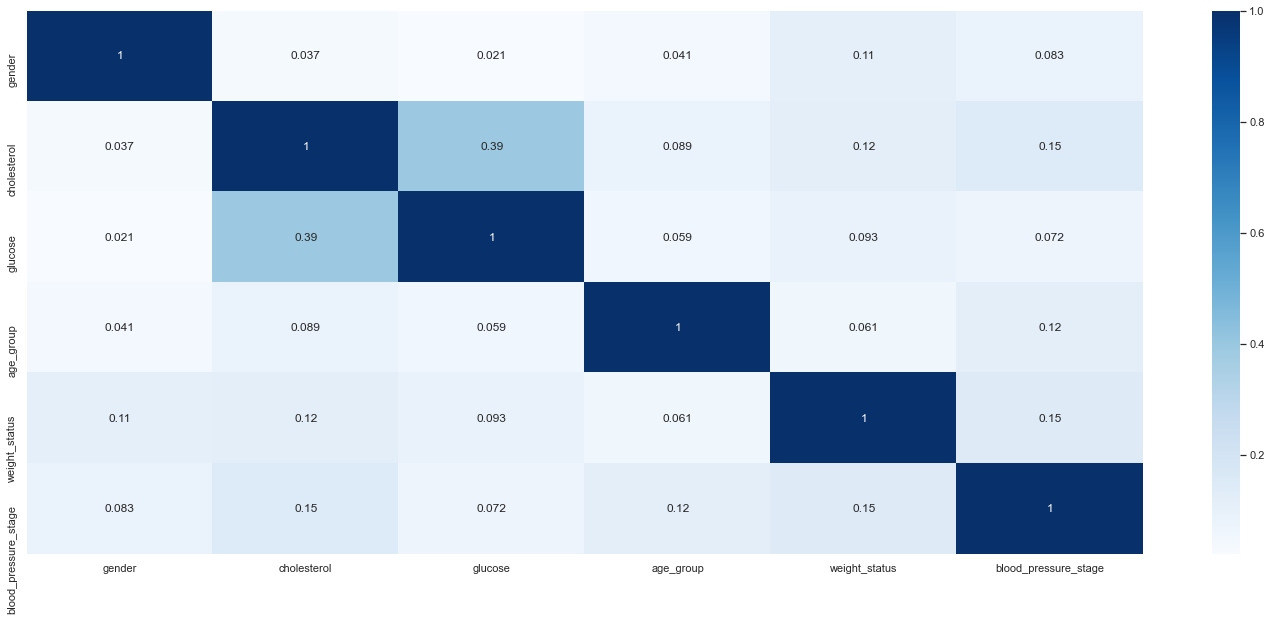

In [71]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['cholesterol'] )
a3 = cramer_v( a['gender'], a['glucose'] )
a4 = cramer_v( a['gender'], a['age_group'] )
a5 = cramer_v( a['gender'], a['weight_status'] )
a6 = cramer_v( a['gender'], a['blood_pressure_stage'] )

a7 = cramer_v( a['cholesterol'], a['gender'] )
a8 = cramer_v( a['cholesterol'], a['cholesterol'] )
a9 = cramer_v( a['cholesterol'], a['glucose'] )
a10 = cramer_v( a['cholesterol'], a['age_group'] )
a11 = cramer_v( a['cholesterol'], a['weight_status'] )
a12 = cramer_v( a['cholesterol'], a['blood_pressure_stage'] )

a13 = cramer_v( a['glucose'], a['gender'] )
a14 = cramer_v( a['glucose'], a['cholesterol'] )
a15 = cramer_v( a['glucose'], a['glucose'] )
a16 = cramer_v( a['glucose'], a['age_group'] )
a17 = cramer_v( a['glucose'], a['weight_status'] )
a18 = cramer_v( a['glucose'], a['blood_pressure_stage'] )

a19 = cramer_v( a['age_group'],  a['gender'] )
a20 = cramer_v( a['age_group'], a['cholesterol'] )
a21 = cramer_v( a['age_group'], a['glucose'] )
a22 = cramer_v( a['age_group'], a['age_group'] )
a23 = cramer_v( a['age_group'],  a['weight_status'] )
a24 = cramer_v( a['age_group'],  a['blood_pressure_stage'] )

a25 = cramer_v( a['weight_status'], a['gender'] )
a26 = cramer_v( a['weight_status'], a['cholesterol'] )
a27 = cramer_v( a['weight_status'], a['glucose'] )
a28 = cramer_v( a['weight_status'], a['age_group'] )
a29 = cramer_v( a['weight_status'],  a['weight_status'] )
a30 = cramer_v( a['weight_status'], a['blood_pressure_stage'] )

a31 = cramer_v( a['blood_pressure_stage'], a['gender'] )
a32 = cramer_v( a['blood_pressure_stage'], a['cholesterol'] )
a33 = cramer_v( a['blood_pressure_stage'], a['glucose'] )
a34 = cramer_v( a['blood_pressure_stage'], a['age_group'] )
a35 = cramer_v( a['blood_pressure_stage'], a['weight_status'] )
a36 = cramer_v( a['blood_pressure_stage'], a['blood_pressure_stage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6],
                   'cholesterol': [a7, a8, a9, a10, a11, a12],
                   'glucose': [a13, a14, a15, a16, a17, a18],
                   'age_group': [a19, a20, a21, a22, a23, a24],
                   'weight_status': [a25, a26, a27, a28, a29, a30],
                   'blood_pressure_stage': [a31, a32, a33, a34, a35, a36],})

d = d.set_index(d.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, cmap="Blues");

# 5.0 DATA PREPARATION

In [72]:
df5 = df4.copy()

In [73]:
df5.columns

Index(['id', 'gender', 'height', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'cholesterol', 'glucose', 'smoking',
       'alcohol', 'physical_activity', 'cardio_disease', 'age_years',
       'age_group', 'BMI', 'weight_status', 'blood_pressure_stage'],
      dtype='object')

## 5.1 Rescaling Features

In [74]:
mms = MinMaxScaler()

# numerical variable different from binary
df5[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_years", "BMI"]] = mms.fit_transform( df5[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_years", "BMI"]])
pickle.dump( mms, open('parameter/numerical_scaler.pkl', 'wb'))


In [75]:
df5.head()

,id,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years,age_group,BMI,weight_status,blood_pressure_stage
0,0,women,0.59375,0.13208,0.33333,0.36364,normal,normal,0,0,1,0,0.43619,more then 50,0.16667,Healthy,high (stage 1)
1,1,men,0.46875,0.27673,0.53333,0.45455,well above normal,normal,0,0,1,1,0.63070,more then 50,0.45333,Obese,high (stage 2)
2,2,men,0.56250,0.14465,0.46667,0.27273,well above normal,normal,0,0,0,1,0.48531,more then 50,0.20000,Healthy,high (stage 1)
3,3,women,0.60417,0.25786,0.60000,0.54545,normal,normal,0,0,1,1,0.35460,40-50,0.31556,Overweight,high (stage 2)
4,4,men,0.46875,0.09434,0.26667,0.18182,normal,normal,0,0,0,0,0.33875,40-50,0.18889,Healthy,low


## 5.2 Features Transformation

### 5.2.1 Encoding

In [76]:
# ONEHOT ENCODING:
# gender
onehot = ["gender", "smoking", "alcohol", "physical_activity", "cardio_disease"]
df5 = pd.get_dummies(df5, columns = onehot, drop_first=True)

# ORDINAL ENCODING:
# cholesterol
df5["cholesterol"] = df5["cholesterol"].map({"normal": 0, "above normal": 1, "well above normal": 2})
# glucose
df5["glucose"] = df5["glucose"].map({"normal": 0, "above normal": 1, "well above normal": 2})
# age_group
df5["age_group"] = df5["age_group"].map({"less then 30":0 ,"30-40": 1, "40-50": 2, "more then 50": 3})
# weight_status
df5["weight_status"] = df5["weight_status"].map({"Underweight": 0, "Healthy": 1,  "Overweight": 2, "Obese": 3})
# blood_pressure_stage
df5["blood_pressure_stage"] = df5["blood_pressure_stage"].map({"low": 0, "normal": 1, "elevated": 2, "high (stage 1)": 3,  "high (stage 2)": 4, "hypertensive crisis": 5})



# 6.0 FEATURE SELECTION

In [77]:
df6 = df5.copy()

## 6.1 Split DataFrame into training and test DataSet

In [78]:
cols_drop = ['cardio_disease_1']
X = df6.drop(cols_drop, axis = 1)
y = df6['cardio_disease_1']

In [79]:
X = df6.copy()
y = df6['cardio_disease_1']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## 6.2 Boruta as Feature selector

In [81]:
# training and test dataset for boruta
#X_train_n = X_train.values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs = -1 )

# define boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit( X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [82]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected Boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

## 6.3 Random Forest as Feature Selector

In [83]:
#rf = RandomForestClassifier(n_estimators=3000, n_jobs=-1)

#sfm = SelectFromModel(estimator=rf)
#sfm.fit(X_train_fs, y_train)

### 6.3.1 Best Features from Random Forest

In [84]:
#best_columns = sfm.get_support()
#best_columns_rf = X_test.loc[:, best_columns].columns.to_list()

## 6.4 Manual Feature Selection

In [85]:
cols_selected_rf = ['id',
                    'height',
                    'weight',
                    'systolic_blood_pressure',
                    'age_years',
                    'BMI',
                    'blood_pressure_stage']

# columns to add:
feat_to_add = ['cardio_disease_1']

# columns full:
cols_selected_rf_full = cols_selected_rf.copy()
cols_selected_rf_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Evarage Model

In [86]:
x_train = X_train[cols_selected_rf]
x_test = X_test[cols_selected_rf]

# Time Series data preparation
x_training = X_train[cols_selected_rf_full]

In [87]:
aux1 = x_test.copy()
aux1['cardio_disease_1'] = y_test.copy()

In [88]:
#predictions
aux2 = aux1[['id','cardio_disease_1']].groupby('id').mean().reset_index()
aux2.rename( columns = {'cardio_disease_1': 'predictions'}, inplace = True)
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'id')
yhat_baseline = aux1['predictions']

In [89]:
#performance
baseline_result = ml_error('Average_Model', y_test, yhat_baseline)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average_Model,0.00000,inf,0.00000


## 7.2 Linear Regression

In [90]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.39895,inf,0.44375


### 7.2.1 Linear Regression Model - Cross Validation

In [91]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,0.43 +/- 0.08,inf +/- nan,0.46 +/- 0.08


## 7.3 Linear Regression Regularized Model - Lasso

In [92]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test, yhat_lrr)
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,0.42986,inf,0.45939


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [93]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose = False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,0.48 +/- 0.06,inf +/- nan,0.5 +/- 0.08


## 7.4 Random Forest Regressor

In [94]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42  ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.65361,inf,0.78558


   ### 7.4.1 Random Forest Regressor - Cross Validation

In [95]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose = True )
rf_result_cv

/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,0.4 +/- 0.15,inf +/- nan,0.45 +/- 0.15


## 7.5 XGBoost Regressor

In [96]:
# model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 3000,
                              eta = 0.03,
                              max_depth = 5,
                              subsample = 0.3,
                              colsample_bytee = 0.9,
                              min_child_weight = 8).fit( x_train, y_train )


# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb))
xgb_result

[22:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.64037,inf,0.77351


### 7.5.1 XGBoost Regressor - Cross Validation

In [97]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

/nKFold Number: 5
[22:20:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/nKFold Number: 4
[22:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/nKFold Number: 3
[22:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,0.39 +/- 0.09,inf +/- nan,0.43 +/- 0.1


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [98]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Average_Model,0.00000,inf,0.00000
0,Linear Regression,0.39895,inf,0.44375
0,Linear Regression - Lasso,0.42986,inf,0.45939
0,XGBoost Regressor,0.64037,inf,0.77351
0,Random Forest Regressor,0.65361,inf,0.78558


### 7.6.2 Real Performance - Cross Validation

In [99]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,0.39 +/- 0.09,inf +/- nan,0.43 +/- 0.1
0,Random Forest,0.4 +/- 0.15,inf +/- nan,0.45 +/- 0.15
0,Linear Regression,0.43 +/- 0.08,inf +/- nan,0.46 +/- 0.08
0,Lasso,0.48 +/- 0.06,inf +/- nan,0.5 +/- 0.08


# 8.0 HYPERPARAMETER FINE TUNING

Fine tuning will be performed in the next CRISP cycle.

# 9.0 TRADUCTION AND ERRO'S INTERPRETATION

In [102]:
df9 = X_test[cols_selected_rf_full]

# rescale
df9["cardio_disease_1"] = np.expm1(df9["cardio_disease_1"])
df9["predictions"] = np.expm1(yhat_xgb)

## 9.1 Business Performance

In [107]:
# sum of predictions
df91 = df9[["id", "predictions"]].groupby("id").sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[["id", "cardio_disease_1", "predictions"]].groupby("id").apply(lambda x: mean_absolute_error(x["cardio_disease_1"], x["predictions"]) ).reset_index().rename(columns={0: "MAE"})

df9_aux2 = df9[["id", "cardio_disease_1", "predictions"]].groupby("id").apply(lambda x: mean_absolute_percentage_error(x["cardio_disease_1"], x["predictions"] ) ).reset_index().rename( columns={0: "MAPE"})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how="inner", on="id")
df92 = pd.merge(df91, df9_aux3, how="inner", on="id")

# Scenarios
df92["worst_scenario"] = df92["predictions"] - df92["MAE"]
df92["best_scenario"] = df92["predictions"] + df92["MAE"]

# order columns
df92 = df92[["id", "predictions", "worst_scenario", "best_scenario", "MAE", "MAPE"]]

In [108]:
df92.sort_values("MAPE", ascending=False).head()

,id,predictions,worst_scenario,best_scenario,MAE,MAPE
0,4,-0.09899,-0.19799,0.00000,0.09899,inf
18621,90393,0.12710,0.00000,0.25419,0.12710,inf
10090,49241,0.68186,0.00000,1.36372,0.68186,inf
18623,90404,0.50500,0.00000,1.01001,0.50500,inf
10092,49245,0.29444,0.00000,0.58888,0.29444,inf
